# Data Mining Project

## Context

Market segmentation, the process of identifying customers’ groups, makes use of geographic, demographic, psychographic, and behavioral characteristics of customers. By understanding the differences between the different segments, organizations can make better strategic choices about opportunities, product definition, positioning, promotions, pricing, and target marketing.

A2Z Insurance (A2Z) is a portuguese long standing insurance company that serves a wide array of insurance services: Motor, Household, Health, Life and Work Compensation. Although A2Z primarily serves portuguese customers, a significant portion of their customer acquisition comes from their web site.

In 2016, A2Z became one of the largest insurers in Portugal.and they provided you an ABT (Analytic Based Table) with data regarding a sample of 10.290 Customers from its active database. These are customers that had at least one insurance service with the company at the time the dataset was extracted. 

## Goals
1. Explore the data and identify the variables that should be used to segment customers.
2. Identify customer segments
3. Justify the number of clusters you chose (taking in consideration the business use as well).
4. Explain the clusters found.
5. Suggest business applications for the findings and define general marketing approaches for each cluster.

## Notes

- 2016 is the current year
- Change Name of Columns X
- Fill with 0 the Insurance Premiums X
- Fill with mode Children X
- Fill with median Salary, etc. X
- Deal with Negative Values
- Remove Outliers (IQR Method and Manual) X
- Perform Standardization (MinMaxScaler,Standard Scaler)
- Feature Selection(Check Correlation)
- Create New Variables (Age Group, Income Group, Has Children (Yes/No, Total_Premiums)
- Taking into account that the current year of the database is 2016, we calculated the customer Age , which is 2016 minus birthday year and the Customer_Years is 2016 minus first policy year. Also, i f we divide Customer Monetary Value ( CMV ) by Customer_Years , we obt ain an estimation of the customer Annual_Profit .
- Coherence Checking (Age < 18, Age < Years of Education+4?, Birthday > First_Policy, Negative Salary, Children outside the Ranges, Area different from the range interval
- Clustering by Demographic and Value and Behavior (Data Partition)
- Create new variable Salary Invested Total Premiums/(Salary x 14) x 100

## Importing Libraries

In [1]:
#!pip install -U git+https://github.com/sevamoo/SOMPY.git

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.base import clone
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, MeanShift, estimate_bandwidth
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from pandas_profiling import ProfileReport
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.lines import Line2D
from matplotlib import __version__ as mplver


import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

## Loading Data

In [3]:
df = pd.read_sas('a2z_insurance.sas7bdat')

In [4]:
df['CustID'] = df.CustID.astype(int)

In [5]:
df.set_index('CustID', inplace=True)

## Data Exploration

In [6]:
#Renaming Columns
df.rename(columns={'FirstPolYear':'First_Policy',
                   'EducDeg': 'Education',
                   'MonthSal': 'Salary',
                  'GeoLivArea': 'Area',
                  'CustMonVal': 'CMV',
                   'ClaimsRate': 'Claims',
                  'PremMotor':'Motor',
                  'PremHousehold': 'Household',
                  'PremHealth': 'Health',
                  'PremLife': 'Life',
                  'PremWork': 'Work'}, inplace=True)

In [7]:
df.head()

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work
CustID,,,,,,,,,,,,,
1,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [8]:
#Checking Shape of the Dataset
df.shape

(10296, 13)

In [9]:
#Checking all the Columns in the Dataset
df.columns

Index(['First_Policy', 'BirthYear', 'Education', 'Salary', 'Area', 'Children',
       'CMV', 'Claims', 'Motor', 'Household', 'Health', 'Life', 'Work'],
      dtype='object')

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
First_Policy,10266.0,1991.062634,511.267913,1974.00,1980.00,1986.00,1992.0000,53784.00
BirthYear,10279.0,1968.007783,19.709476,1028.00,1953.00,1968.00,1983.0000,2001.00
Salary,10260.0,2506.667057,1157.449634,333.00,1706.00,2501.50,3290.2500,55215.00
Area,10295.0,2.709859,1.266291,1.00,1.00,3.00,4.0000,4.00
Children,10275.0,0.706764,0.455268,0.00,0.00,1.00,1.0000,1.00
CMV,10296.0,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
Claims,10296.0,0.742772,2.916964,0.00,0.39,0.72,0.9800,256.20
Motor,10262.0,300.470252,211.914997,-4.11,190.59,298.61,408.3000,11604.42
Household,10296.0,210.431192,352.595984,-75.00,49.45,132.80,290.0500,25048.80
Health,10253.0,171.580833,296.405976,-2.11,111.80,162.81,219.8200,28272.00


In [11]:
#Checking information for all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10296 entries, 1 to 10296
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   First_Policy  10266 non-null  float64
 1   BirthYear     10279 non-null  float64
 2   Education     10279 non-null  object 
 3   Salary        10260 non-null  float64
 4   Area          10295 non-null  float64
 5   Children      10275 non-null  float64
 6   CMV           10296 non-null  float64
 7   Claims        10296 non-null  float64
 8   Motor         10262 non-null  float64
 9   Household     10296 non-null  float64
 10  Health        10253 non-null  float64
 11  Life          10192 non-null  float64
 12  Work          10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [12]:
#Checking if there is any Null value present in the Dataset?
df.isnull().sum()

First_Policy     30
BirthYear        17
Education        17
Salary           36
Area              1
Children         21
CMV               0
Claims            0
Motor            34
Household         0
Health           43
Life            104
Work             86
dtype: int64

In [13]:
### Percentage of Missing Data
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
First_Policy,First_Policy,0.291375
BirthYear,BirthYear,0.165113
Education,Education,0.165113
Salary,Salary,0.349650
Area,Area,0.009713
Children,Children,0.203963
CMV,CMV,0.000000
Claims,Claims,0.000000
Motor,Motor,0.330225
Household,Household,0.000000


## Data Preparation

### Handling Missing Values

In [14]:
df['First_Policy'].median()

1986.0

In [15]:
df['First_Policy'].fillna(df['First_Policy'].median(), inplace=True)

In [16]:
df['BirthYear'].median()

1968.0

In [17]:
df['BirthYear'].fillna(df['BirthYear'].median(), inplace=True)

In [18]:
df['Education'].mode()[0]

b'3 - BSc/MSc'

In [19]:
df['Education'].fillna(df['Education'].mode()[0], inplace=True)

In [20]:
df['Salary'].median()

2501.5

In [21]:
df['Salary'].fillna(df['Salary'].median(), inplace=True)

In [22]:
df['Area'].median()

3.0

In [23]:
df['Area'].fillna(df['Area'].median(), inplace=True)

In [24]:
#We assume that Nan means that they don't have kids
df['Children'].fillna(0, inplace=True)

In [25]:
df['Motor'].fillna(0, inplace=True)
df['Health'].fillna(0, inplace=True)
df['Life'].fillna(0, inplace=True)
df['Work'].fillna(0, inplace=True)

In [26]:
df.isnull().sum()

First_Policy    0
BirthYear       0
Education       0
Salary          0
Area            0
Children        0
CMV             0
Claims          0
Motor           0
Household       0
Health          0
Life            0
Work            0
dtype: int64

In [27]:
df['First_Policy'] = df['First_Policy'].astype(int)
df['BirthYear'] = df['BirthYear'].astype(int)
df['Area'] = df['Area'].astype(int)
df['Children'] = df['Children'].astype(int)

## Notes:

## Handling Outliers

In [28]:
#Define metric and non-metric features. Why?
non_metric_features = ["Education", "Area", "Children"]
metric_features = df.columns.drop(non_metric_features).to_list()

In [29]:
# let's keep the central imputation
df_copy = df.copy()

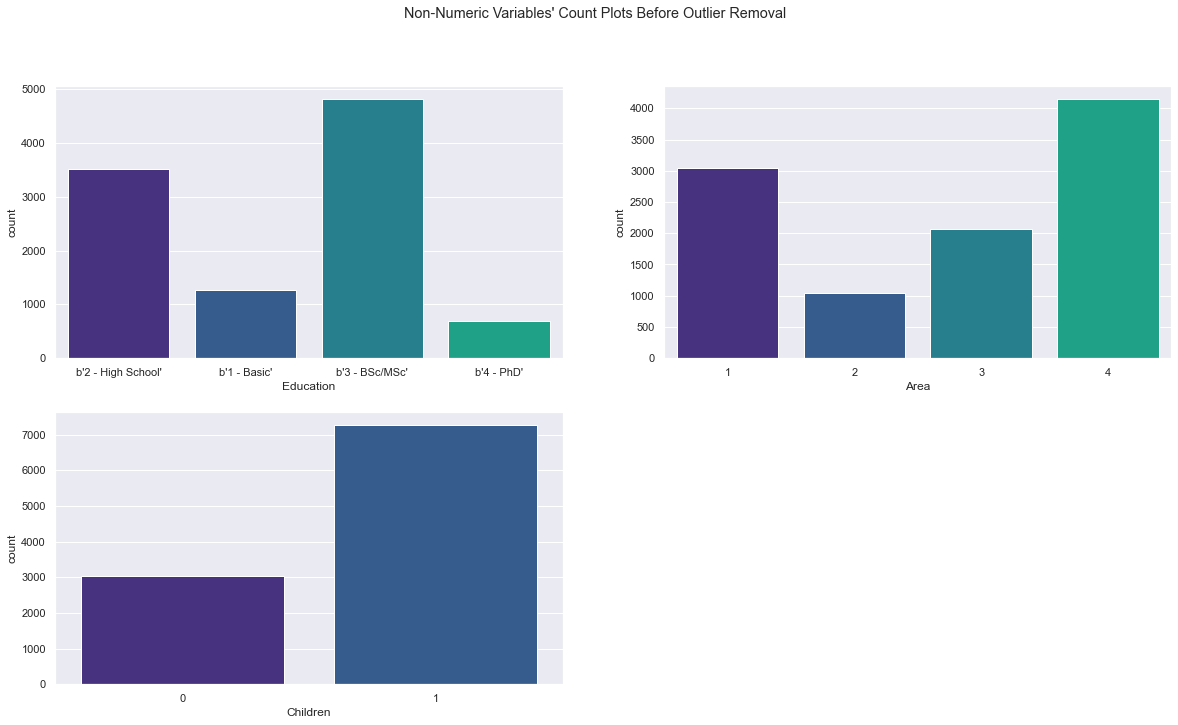

In [30]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df[feat], ax=ax, palette=sns.color_palette('viridis'), saturation=1)
    
fig.delaxes(axes[1,1])
# Layout
# Add a centered title to the figure:
title = "Non-Numeric Variables' Count Plots Before Outlier Removal"

plt.suptitle(title)

plt.show()

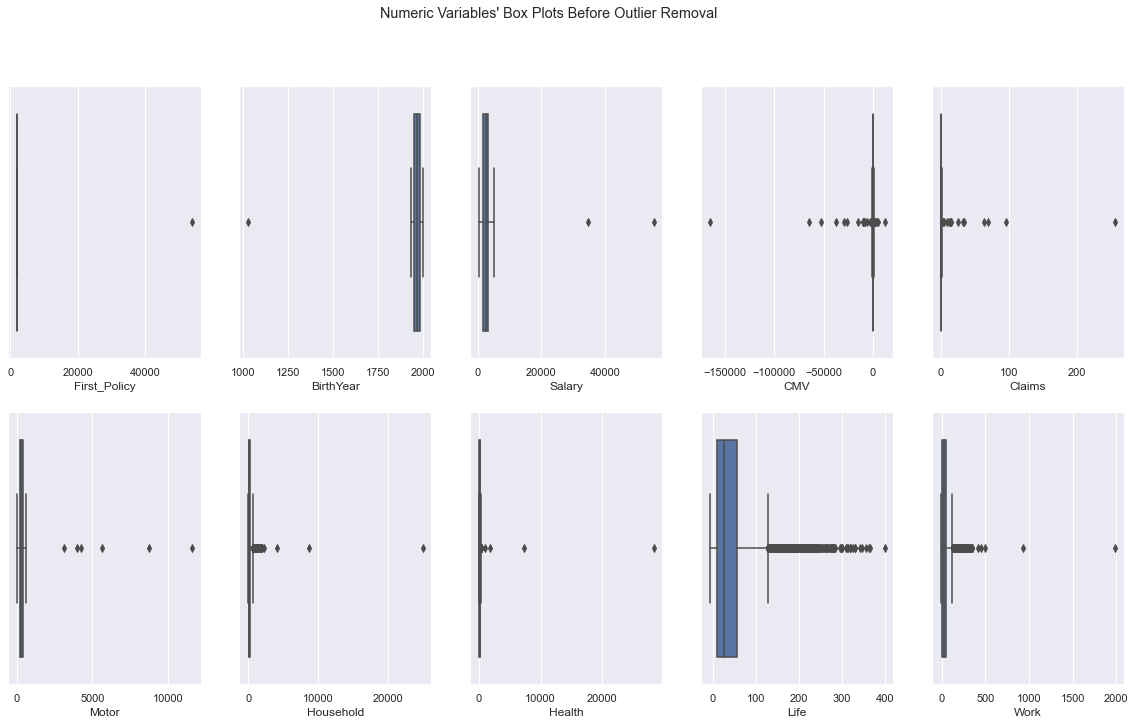

In [31]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots Before Outlier Removal"

plt.suptitle(title)

plt.show()

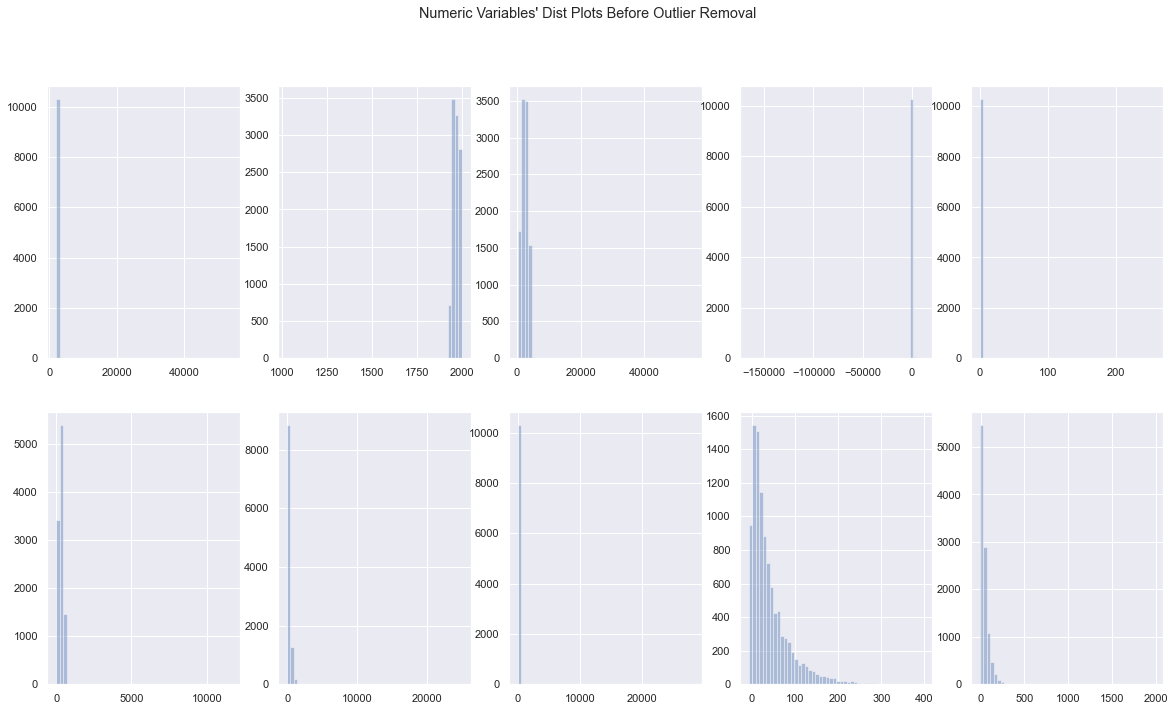

In [32]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.distplot(x=df[feat], ax=ax, kde=False)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Dist Plots Before Outlier Removal"

plt.suptitle(title)

plt.show()

### Manual method

In [33]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (df['BirthYear'] > 1800)
    &
    (df['First_Policy'] < 20000)
    &
    (df['Salary'] <= 5000)
    &
    (df['CMV'] <= 1000) & (df['CMV'] > -1500)
    &
    (df['Claims'] <= 4)
    &
    (df['Motor'] <= 1500)
    &
    (df['Household'] <= 500)
    &
    (df['Health'] <= 400)
    &
    (df['Life'] <= 100)
    &
    (df['Work'] <= 100)
)

df_1 = df_copy[filters1]

In [34]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.777


### IQR method

In [35]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df_copy[metric].between(llim, ulim, inclusive='both'))
    print(f" {metric} , {llim}, {ulim}")

df_2 = df[np.all(filters2,0)]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

 First_Policy , 1962.0, 2010.0
 BirthYear , 1908.0, 2028.0
 Salary , -662.25, 5659.75
 CMV , -623.2662500000001, 1013.6037500000001
 Claims , -0.495, 1.865
 Motor , -135.63, 733.41
 Household , -311.45000000000005, 650.95
 Health , -51.161250000000024, 381.02875000000006
 Life , -60.78999999999999, 127.69
 Work , -59.015, 125.025
Percentage of data kept after removing outliers: 0.8555


In [36]:
df_3 = df_copy[(filters1 | np.all(filters2,0))]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.8568


In [37]:
#Applying it to the DataFrame
df = df[(filters1 | np.all(filters2,0))]

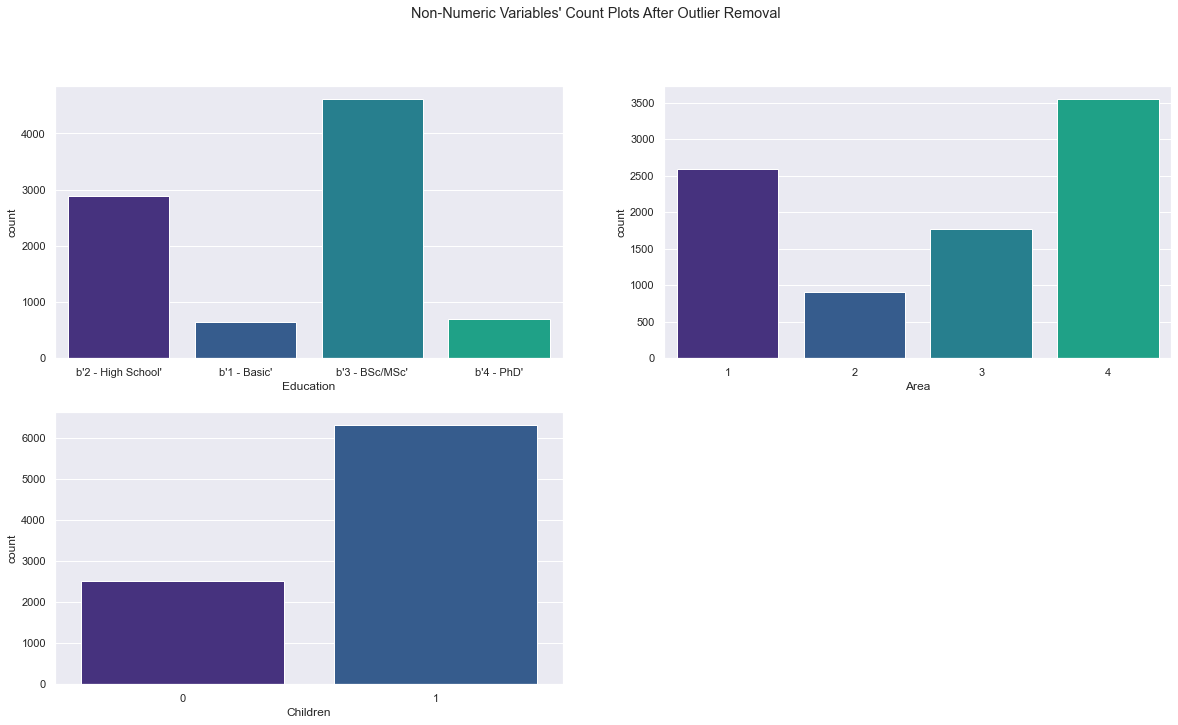

In [38]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df[feat], ax=ax, palette=sns.color_palette('viridis'), saturation=1)
    
fig.delaxes(axes[1,1])
# Layout
# Add a centered title to the figure:
title = "Non-Numeric Variables' Count Plots After Outlier Removal"

plt.suptitle(title)

plt.show()

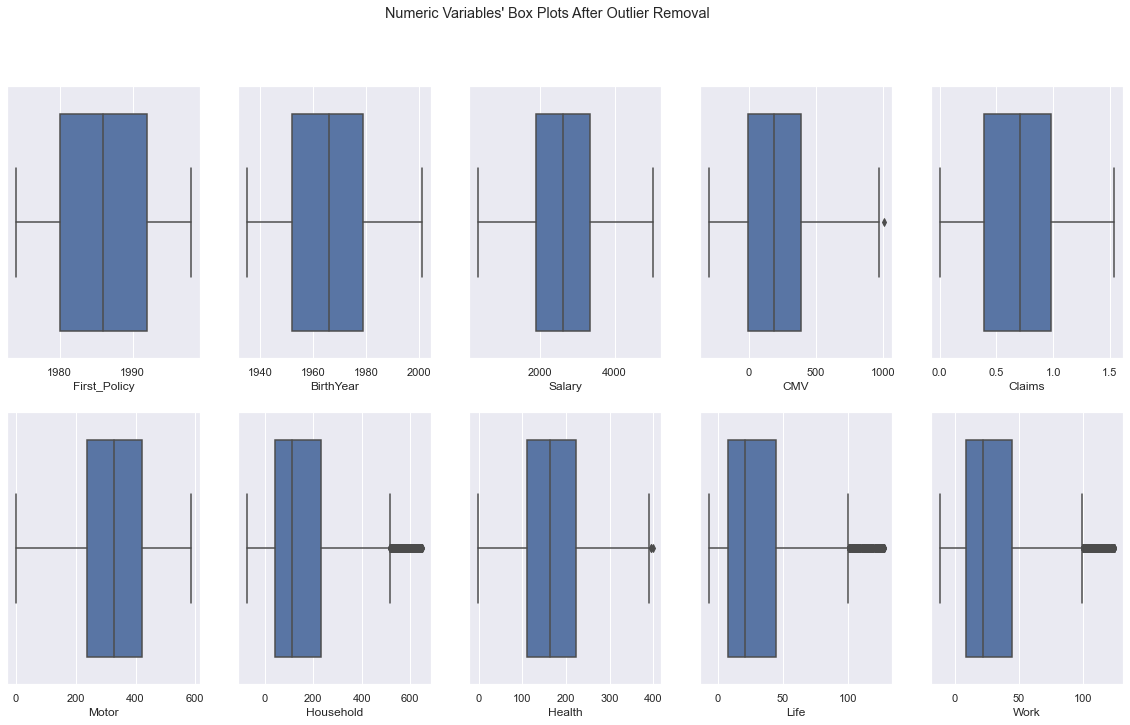

In [39]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots After Outlier Removal"

plt.suptitle(title)

plt.show()

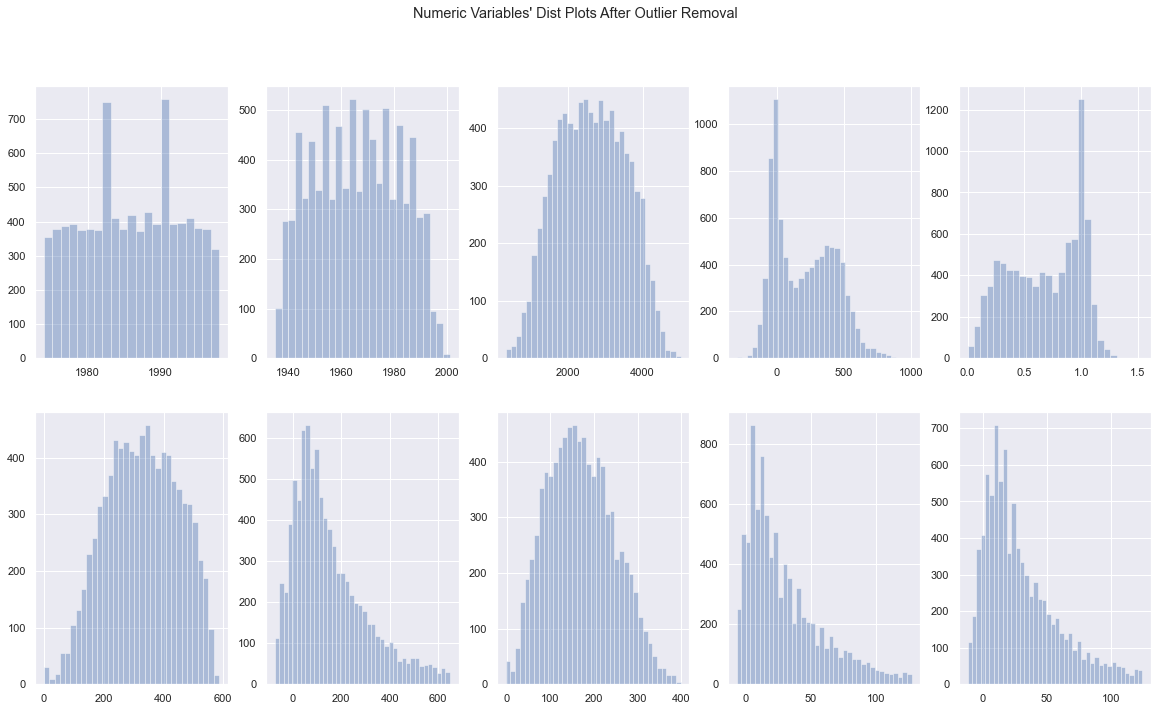

In [40]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.distplot(x=df[feat], ax=ax, kde=False)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Dist Plots After Outlier Removal"

plt.suptitle(title)

plt.show()

## Data Preprocessing

### List
- Age X
- Customer Years (Loyalty years) X
- Total Premium X
- Customer Annual Profit X
- Salary Invested Total Premiums/(Salary x 14) x 100 X
- Change Education

## Questions
Minimum Age and Customer Years for insurance?
<br>
Group By age?
<br>
Should we remove negative values from premiums?
<br>
Customer Monetary Value (CMV) can be negative?

In [41]:
#Age of Customer
df['Age'] = 2016 - df['BirthYear']

In [42]:
#Number of Years of Loyalty
df['Customer_Years'] = 2016 - df['First_Policy']

In [43]:
#Removing negative values because customers no longer possess that kind of premium
df['Work'][df['Work']<=0] = 0
df['Life'][df['Life']<=0] = 0
df['Health'][df['Health']<=0] = 0
df['Motor'][df['Motor'] <= 0] = 0
df['Household'][df['Household'] <= 0] = 0

In [44]:
#Summing All premiums
df['Total_Premium'] = df['Work'] + df['Life'] + df['Health'] + df['Motor'] + df['Household']

In [45]:
#Annually Rate of Salary Invested in Premiums
df['Salary_Rate'] = (df['Total_Premium'] / (df['Salary'] * 14)) * 100

In [46]:
def binary_education(x):
    """Function that receives values for Education and assigns their ranking(1,2,3,4)"""
    if x == b'1 - Basic':
        return 1
    elif x == b'2 - High School':
        return 2
    elif x == b'3 - BSc/MSc':
        return 3
    elif x == b'4 - PhD':
        return 4

In [47]:
#Transformin Categorical Variable into Ordinal Variable (Ranking Education)
df['Education'] = df['Education'].apply(lambda x : binary_education(x))

In [48]:
df.head()

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work,Age,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,,,,,,,
1,1985,1982,2,2177.0,1,1,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34,31,665.56,2.183739
3,1991,1970,1,2277.0,3,0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46,25,740.60,2.323232
4,1990,1981,3,1099.0,4,1,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35,26,600.68,3.904069
5,1986,1973,3,1763.0,4,1,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43,30,629.24,2.549388
6,1986,1956,2,2566.0,4,1,-24.33,1.00,440.75,18.90,114.80,7.00,7.67,60,30,589.12,1.639906


## Coherence Checking

#Generally speaking, the minimum age of entry for life insurance plans like term plans and whole life plans is 18 years.
#The maximum age of entry ranges from 65 to 69 years, depending on the type of plan and insurer.

In [49]:
#age - customer_years >= 0 == #customer_years > age
df[df['Age'] - df['Customer_Years'] >= 0]

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work,Age,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,,,,,,,
1,1985,1982,2,2177.0,1,1,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34,31,665.56,2.183739
3,1991,1970,1,2277.0,3,0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46,25,740.60,2.323232
4,1990,1981,3,1099.0,4,1,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35,26,600.68,3.904069
5,1986,1973,3,1763.0,4,1,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43,30,629.24,2.549388
6,1986,1956,2,2566.0,4,1,-24.33,1.00,440.75,18.90,114.80,7.00,7.67,60,30,589.12,1.639906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,1986,1943,2,3498.0,4,0,245.60,0.67,227.82,270.60,160.92,100.13,69.90,73,30,829.37,1.693560
10292,1984,1949,4,3188.0,2,0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,67,32,641.56,1.437444
10294,1994,1976,3,2918.0,1,1,524.10,0.21,403.63,132.80,142.25,12.67,4.89,40,22,696.24,1.704298


In [50]:
# age <= 18 has children
df[(df['Age'] <= 18) & (df['Children'] == 1)]

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work,Age,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,,,,,,,
1447,1997,1999,1,388.0,4,1,798.49,0.25,60.90,637.90,275.83,48.12,76.57,17,19,1099.32,20.237850
2147,1977,1998,1,1195.0,4,1,334.83,0.59,362.18,310.60,106.13,46.23,49.23,18,39,874.37,5.226360
2607,1992,1998,1,566.0,1,1,97.91,0.84,102.02,230.05,337.84,58.01,37.12,18,24,765.04,9.654720
3374,1988,1998,1,482.0,4,1,-81.90,1.06,103.24,362.85,280.83,48.23,105.13,18,28,900.28,13.341434
3996,1989,1998,2,1250.0,1,1,117.25,0.85,34.34,428.40,287.72,107.91,98.35,18,27,956.72,5.466971
4317,1998,1999,1,876.0,2,1,102.47,0.88,127.47,564.00,147.25,66.68,115.80,17,18,1021.20,8.326810
4995,1984,1998,2,564.0,4,1,79.13,0.90,125.58,511.75,165.81,104.13,98.13,18,32,1005.40,12.733029
5348,1980,2001,1,1119.0,3,1,796.71,0.23,148.14,628.45,221.82,45.12,30.23,15,36,1073.76,6.854079
5544,1988,1998,2,1726.0,4,1,-21.22,1.00,102.13,585.10,201.37,85.35,89.13,18,28,1063.08,4.399437


In [51]:
#Age > Education [Basic == 4 years] + [High School == 12 years] + [BSc/MSc <= 15] + [PhD <= 20]
df[(df['Age'] <= 25) & (df['Education'] == 4)]

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work,Age,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,,,,,,,
710,1986,1991,4,689.0,1,1,-30.89,1.01,212.93,147.80,294.50,28.56,34.45,25,30,718.24,7.445988
818,1982,1992,4,1541.0,4,1,640.57,0.00,329.73,83.35,222.93,6.89,22.67,24,34,665.57,3.085056
1264,1996,1991,4,1118.0,3,1,3.79,0.95,363.18,38.35,174.59,1.89,7.67,25,20,585.68,3.741886
2169,1989,1991,4,1372.0,1,1,485.21,0.29,287.50,176.70,186.59,12.78,58.79,25,27,722.36,3.760725
3108,1992,1992,4,1261.0,1,1,298.95,0.53,314.06,138.35,216.82,13.67,9.89,24,24,692.79,3.924266
3261,1978,1992,4,1654.0,1,1,288.17,0.52,276.72,93.35,210.93,41.34,36.45,24,38,658.79,2.845008
4123,1982,1993,4,1900.0,1,1,16.01,0.94,333.73,87.80,170.70,21.56,19.45,23,34,633.24,2.380602
5238,1984,1993,4,1374.0,4,1,-37.89,1.02,509.65,70.00,72.57,12.89,2.89,23,32,668.00,3.472655
8085,1994,1993,4,971.0,4,1,476.19,0.33,297.61,158.35,223.82,19.67,45.23,23,22,744.68,5.478005


What Is the Minimum Age for Getting a PhD? To get a PhD, you have to have graduated from undergraduate school. From there, some people can go right into a PhD program. If you graduate at the traditional age of 22, you'd be getting your PhD somewhere around age 25 at a minimum

In [52]:
df[(df['Age'] <= 20) & (df['Education'] == 3)]

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work,Age,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,,,,,,,
382,1977,1996,3,1165.0,4,1,570.10,0.45,183.59,595.1,135.58,121.80,48.90,20,39,1084.97,6.652177
984,1994,1996,3,1320.0,3,1,562.90,0.44,84.24,587.9,268.94,2.00,106.24,20,22,1049.32,5.678139
1527,1977,1996,3,1152.0,1,1,259.50,0.63,206.04,236.7,257.16,25.56,52.90,20,39,778.36,4.826141
1617,1981,1996,3,1548.0,1,1,283.40,0.55,240.60,136.7,140.47,59.79,111.91,20,35,689.47,3.181386
2661,1981,1996,3,1548.0,1,1,-84.79,1.10,240.60,136.7,140.47,59.79,0.00,20,35,577.56,2.665006
2993,1992,1996,3,1842.0,4,1,340.30,0.41,178.59,67.8,258.05,72.57,46.34,20,24,623.35,2.417210
6483,1997,1996,3,1382.0,1,1,-54.67,1.03,89.24,587.9,228.82,118.91,11.56,20,19,1036.43,5.356781
7896,1984,1996,3,1378.0,4,0,84.14,0.84,161.03,136.7,313.06,27.56,53.01,20,32,691.36,3.583662


In [53]:
df[(df['Age'] <= 18) & (df['Education'] == 2)]

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work,Age,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,,,,,,,
3996,1989,1998,2,1250.0,1,1,117.25,0.85,34.34,428.40,287.72,107.91,98.35,18,27,956.72,5.466971
4995,1984,1998,2,564.0,4,1,79.13,0.90,125.58,511.75,165.81,104.13,98.13,18,32,1005.40,12.733029
5544,1988,1998,2,1726.0,4,1,-21.22,1.00,102.13,585.10,201.37,85.35,89.13,18,28,1063.08,4.399437
7252,1993,1998,2,1133.0,4,0,400.74,0.52,56.79,368.95,298.39,96.24,70.79,18,23,891.16,5.618207
7917,1992,1998,2,1207.0,3,0,574.12,0.41,97.13,549.00,243.38,50.12,67.57,18,24,1007.20,5.960469
8836,1985,1998,2,773.0,1,1,518.31,0.50,40.23,605.10,272.05,61.79,110.91,18,31,1090.08,10.072815
9458,1976,1998,2,614.0,1,1,-32.00,1.01,97.13,511.20,261.16,44.23,104.13,18,40,1017.85,11.840973
9481,1983,1998,2,1323.0,3,1,387.07,0.50,112.02,300.05,287.50,47.01,77.57,18,33,824.15,4.449573
9634,1986,1998,2,1067.0,1,0,652.12,0.29,101.02,457.30,179.70,126.69,93.13,18,30,957.84,6.412103


In [54]:
df[(df['Age'] <= 18) & (df['Education'] == 1)]

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work,Age,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,,,,,,,
1447,1997,1999,1,388.0,4,1,798.49,0.25,60.90,637.90,275.83,48.12,76.57,17,19,1099.32,20.237850
2147,1977,1998,1,1195.0,4,1,334.83,0.59,362.18,310.60,106.13,46.23,49.23,18,39,874.37,5.226360
2580,1986,2001,1,1006.0,4,0,267.95,0.67,48.23,396.75,291.50,127.58,24.45,15,30,888.51,6.308648
2607,1992,1998,1,566.0,1,1,97.91,0.84,102.02,230.05,337.84,58.01,37.12,18,24,765.04,9.654720
3374,1988,1998,1,482.0,4,1,-81.90,1.06,103.24,362.85,280.83,48.23,105.13,18,28,900.28,13.341434
4317,1998,1999,1,876.0,2,1,102.47,0.88,127.47,564.00,147.25,66.68,115.80,17,18,1021.20,8.326810
5348,1980,2001,1,1119.0,3,1,796.71,0.23,148.14,628.45,221.82,45.12,30.23,15,36,1073.76,6.854079
5967,1979,1998,1,838.0,4,1,74.24,0.91,72.79,604.00,193.37,116.80,99.24,18,37,1086.20,9.258438
7405,1997,2000,1,865.0,1,0,472.97,0.42,62.68,330.05,283.61,83.46,105.24,16,19,865.04,7.143187


In [55]:
# delete all rows with column 'Age' has value 30 to 40
#df.drop(indexAge , inplace=True)
#df.head(15)

##### Examples of demographic characteristics include age, race, gender, ethnicity, religion, income, education, home ownership, sexual orientation, marital status, family size, health and disability status, and psychiatric diagnosis."

In [56]:
#1108
df.loc[df['Household'] == 0]

,First_Policy,BirthYear,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work,Age,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,,,,,,,
15,1983,1975,2,1981.0,1,1,-89.00,1.12,504.43,0.0,72.79,10.89,16.89,41,33,605.00,2.181438
31,1988,1975,2,2148.0,4,1,427.76,0.19,483.09,0.0,92.24,3.89,0.00,41,28,579.22,1.926111
37,1982,1972,2,2401.0,4,1,7.24,0.94,320.95,0.0,145.25,26.56,84.35,44,34,577.11,1.716874
49,1985,1974,3,2381.0,3,1,-132.88,1.20,468.09,0.0,92.24,1.89,14.89,42,31,577.11,1.731295
53,1986,1984,3,1960.0,3,1,-104.21,1.14,360.40,0.0,212.04,12.78,10.89,32,30,596.11,2.172413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10243,1991,1978,3,2816.0,1,1,242.52,0.51,338.73,0.0,224.93,11.67,11.78,38,25,587.11,1.489220
10251,1997,1957,3,2809.0,1,1,-40.11,1.03,362.18,0.0,166.92,49.12,14.89,59,19,593.11,1.508188
10253,1978,1968,3,2499.0,1,1,-84.00,1.11,532.10,0.0,43.12,3.89,2.89,48,38,582.00,1.663523


A higher Incurred Claim Ratio is good news for you, the investor or the existing policyholder because it indicates that the company is successfully meeting claims made on it. Therefore, you can put a higher amount of trust on insurers having a high Incurred Claim Ratio.

## Data Partition
- Demographic (Age, Salary, Area, Education, Children)
- Insurance (Work, Life, Health, Household, Motor)

In [57]:
demo_df = pd.DataFrame(df, columns=['BirthYear','Age', 'Education', 'Salary', 'Area','Children'])

In [58]:
demo_df.head()

,BirthYear,Age,Education,Salary,Area,Children
CustID,,,,,,
1,1982,34,2,2177.0,1,1
3,1970,46,1,2277.0,3,0
4,1981,35,3,1099.0,4,1
5,1973,43,3,1763.0,4,1
6,1956,60,2,2566.0,4,1


In [59]:
insurance_df = pd.DataFrame(df, columns=['First_Policy', 'CMV', 'Claims', 'Motor', 'Household',
                                         'Life', 'Health', 'Work', 'Customer_Years', 'Total_Premium', 'Salary_Rate'])

In [60]:
insurance_df.head()

,First_Policy,CMV,Claims,Motor,Household,Life,Health,Work,Customer_Years,Total_Premium,Salary_Rate
CustID,,,,,,,,,,,
1,1985,380.97,0.39,375.85,79.45,47.01,146.36,16.89,31,665.56,2.183739
3,1991,504.67,0.28,206.15,224.50,86.35,124.58,99.02,25,740.60,2.323232
4,1990,-16.99,0.99,182.48,43.35,35.34,311.17,28.34,26,600.68,3.904069
5,1986,35.23,0.90,338.62,47.80,18.78,182.59,41.45,30,629.24,2.549388
6,1986,-24.33,1.00,440.75,18.90,7.00,114.80,7.67,30,589.12,1.639906


## Feature Selection

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000280B3438850>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000280B3438850> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


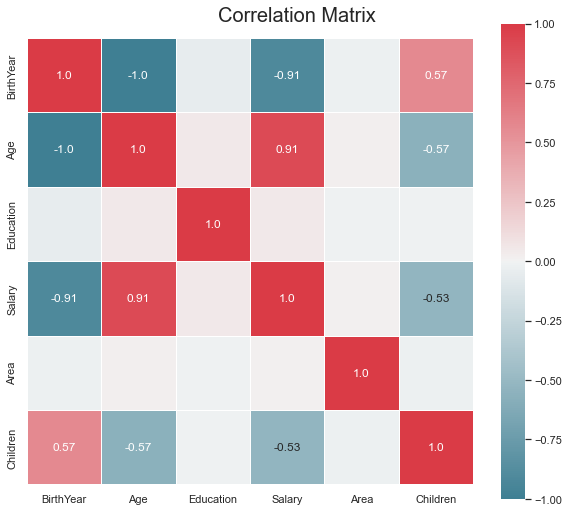

In [61]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(demo_df.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)


plt.show()

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000280B29BA070>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000280B29BA070> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


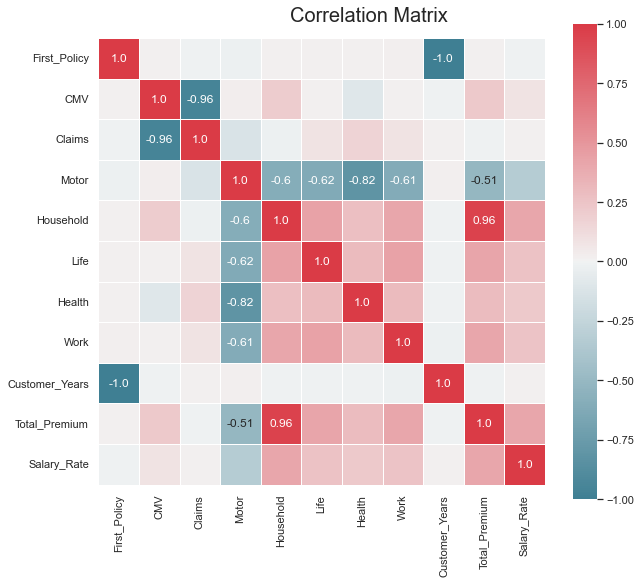

In [62]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(insurance_df.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)


plt.show()

## Insights

<h4>Demo DataFrame</h4>
<ul>
<li>Age vs BirthYear</li>
<li>Salary vs BirthYear</li>
<li>Age vs Salary</li>
</ul>

<h4>Insurance DataFrame</h4>
<ul>
<li>Household vs Total_Premium</li>
<li>Claims vs CMV</li>
</ul>

We decided to drop BirthYear, Claims, Total_Premium

In [63]:
demo_df.drop(['BirthYear','Age'], axis=1, inplace=True)

In [64]:
insurance_df.drop(['Total_Premium', 'Claims'], axis=1, inplace=True)

## Data Standardization/Normalization

<h4>Standart Scaler</h4>
<ul>
    <li>It works well at outlier detection.</li>
    <li>Features need to be the same type. If one feature represents count and one represents length, that will cause a negative effect on data.</li>
    <li>Normalizing your data will scale most of your data to a small interval if you have outliers in your feature.</li>

<h4>MinMax Scaler</h4>
<ul>
<li>It preserves the shape of the original distribution.</li>
<li>The default range for the feature returned by MinMaxScaler is 0 to 1.</li>
<li>The importance of outlier values doesn’t affect, so those can be used for outlier detection algorithms.</li>
 </ul>

<h4>Robust Scaler</h4>
<ul>
<li>There is no default range to scale the data like MinMax Scaler.</li>
<li>It doesn’t work well for outlier detection.</li>
<li>It reduces the effects of outliers.</li>
<li>Value range is interquartile range (Quartile 1 to Quartile 3)</li>
</ul>

In [65]:
demo_non_metric_features = []
demo_metric_features = demo_df.columns.drop(non_metric_features).to_list()

In [66]:
demo_df_scaled = StandardScaler().fit_transform(demo_df[demo_metric_features])
demo_df[demo_metric_features] = demo_df_scaled
demo_df_scaled

array([[-0.48549229],
       [-0.37576227],
       [-1.66838195],
       ...,
       [ 0.32760718],
       [-0.71153614],
       [ 0.21458526]])

In [67]:
demo_df.head()

,Education,Salary,Area,Children
CustID,,,,
1,2,-0.485492,1,1
3,1,-0.375762,3,0
4,3,-1.668382,4,1
5,3,-0.939775,4,1
6,2,-0.058643,4,1


In [68]:
demo_df_minmax = MinMaxScaler().fit_transform(demo_df)
demo_df_minmax

array([[0.33333333, 0.39334471, 0.        , 1.        ],
       [0.        , 0.41467577, 0.66666667, 0.        ],
       [0.66666667, 0.1633959 , 1.        , 1.        ],
       ...,
       [0.66666667, 0.55140785, 0.        , 1.        ],
       [0.        , 0.34940273, 0.33333333, 1.        ],
       [1.        , 0.52943686, 0.        , 1.        ]])

In [69]:
demo_df_robust = RobustScaler().fit_transform(demo_df)
demo_df_robust

array([[-1.        , -0.30111266, -0.66666667,  0.        ],
       [-2.        , -0.23157163,  0.        , -1.        ],
       [ 0.        , -1.05076495,  0.33333333,  0.        ],
       ...,
       [ 0.        ,  0.21418637, -0.66666667,  0.        ],
       [-2.        , -0.44436718, -0.33333333,  0.        ],
       [ 1.        ,  0.14255911, -0.66666667,  0.        ]])

In [70]:
insurance_df_scaled = StandardScaler().fit_transform(insurance_df)
insurance_df_scaled

array([[-0.15248088,  0.79564857,  0.39919089, ..., -0.4698146 ,
         0.15248088, -0.08911034],
       [ 0.7584805 ,  1.35280166, -0.99653387, ...,  2.41699241,
        -0.7584805 ,  0.00957812],
       [ 0.6066536 , -0.99678993, -1.19121157, ..., -0.06735582,
        -0.6066536 ,  1.12798579],
       ...,
       [ 1.21396119,  1.44031568,  0.62767194, ..., -0.89160547,
        -1.21396119, -0.42830428],
       [-0.75978846,  0.20597612, -1.14095889, ...,  2.90521534,
         0.75978846,  0.35274716],
       [ 0.6066536 ,  1.16849524,  0.71361963, ..., -0.61041156,
        -0.6066536 , -0.43208136]])

In [71]:
insurance_df_minmax = MinMaxScaler().fit_transform(insurance_df)
insurance_df_minmax

array([[0.45833333, 0.52196077, 0.64223711, ..., 0.13533654, 0.54166667,
        0.10790371],
       [0.70833333, 0.61692833, 0.35226069, ..., 0.79342949, 0.29166667,
        0.1147964 ],
       [0.66666667, 0.21643699, 0.31181436, ..., 0.22708333, 0.33333333,
        0.19290926],
       ...,
       [0.83333333, 0.63184523, 0.68970644, ..., 0.03918269, 0.16666667,
        0.08421342],
       [0.29166667, 0.42145023, 0.32225488, ..., 0.90472756, 0.70833333,
        0.13876433],
       [0.66666667, 0.58551303, 0.70756297, ..., 0.10328526, 0.33333333,
        0.08394961]])

In [72]:
insurance_df_robust = RobustScaler().fit_transform(insurance_df)
insurance_df_robust

array([[-0.08333333,  0.48528601,  0.25135323, ..., -0.13497102,
         0.08333333,  0.26979989],
       [ 0.41666667,  0.7953577 , -0.65812745, ...,  2.13193486,
        -0.41666667,  0.39440534],
       [ 0.33333333, -0.51225748, -0.78498312, ...,  0.18106542,
        -0.33333333,  1.80652277],
       ...,
       [ 0.66666667,  0.84406176,  0.40023581, ..., -0.46618824,
        -0.66666667, -0.15847121],
       [-0.41666667,  0.15711636, -0.75223753, ...,  2.5153188 ,
         0.41666667,  0.82769545],
       [ 0.33333333,  0.69278588,  0.45624096, ..., -0.24537676,
        -0.33333333, -0.1632402 ]])

## Insights

After evaluating the differente methods we decided to go with StandardScaler because the use of it brings more advantages 

## Dimensionality Reduction

In [73]:
df_pca = insurance_df.copy()

In [74]:
features = list(insurance_df.columns)

In [75]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca)
pca_feat  # What is this output?

array([[ 1.49963903e+02, -1.25062629e+02, -3.79436340e+01, ...,
         1.42833384e+00,  8.40795061e-02,  3.16120107e-12],
       [ 3.16015202e+02,  5.85209299e+01, -4.15374080e+01, ...,
        -6.54243525e+00, -4.55545078e-01, -2.61123978e-14],
       [-2.35146449e+02,  1.00593692e+02, -1.92095289e+02, ...,
        -5.50256711e+00,  1.80394600e+00, -2.52538457e-14],
       ...,
       [ 2.99584387e+02, -1.40873955e+02, -4.98728934e+00, ...,
        -1.12714694e+01, -3.56904001e-01, -2.55821911e-14],
       [ 6.65192568e+01,  1.33890392e+02, -6.16791042e+01, ...,
         7.40100876e+00, -1.51009363e-01, -2.52779131e-14],
       [ 2.31224342e+02, -1.61239381e+02, -1.57165435e+01, ...,
        -5.65287170e+00, -2.70105558e-01, -2.57669050e-14]])

In [76]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,5.101449e+04,0.000000,5.460030e-01,0.546003
2,3.112244e+04,-19892.055024,3.331004e-01,0.879103
3,9.074326e+03,-22048.113889,9.712160e-02,0.976225
4,1.424801e+03,-7649.524853,1.524950e-02,0.991475
5,4.702314e+02,-954.569353,5.032840e-03,0.996507
6,2.379971e+02,-232.234342,2.547259e-03,0.999055
7,8.671511e+01,-151.281991,9.281031e-04,0.999983
8,1.615940e+00,-85.099166,1.729524e-05,1.000000
9,1.763286e-27,-1.615940,1.887227e-32,1.000000


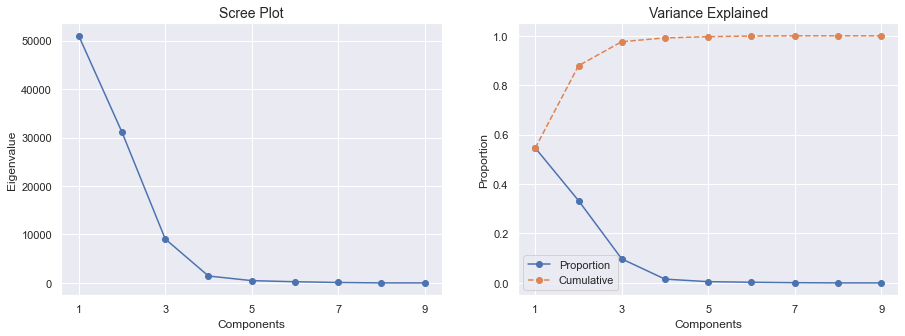

In [77]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [78]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=4)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2,PC3
CustID,,,,
1,149.963903,-125.062629,-37.943634,12.068837
3,316.015202,58.520930,-41.537408,119.829232
4,-235.146449,100.593692,-192.095289,-18.887261
5,-190.763284,-41.614836,-47.824197,3.772610
6,-260.884340,-136.092576,32.046334,-4.560882
...,...,...,...,...
10290,75.031819,140.053570,18.333797,69.566569
10292,-227.833834,-72.997141,-7.135057,-27.532836
10294,299.584387,-140.873955,-4.987289,-23.715821


In [79]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,First_Policy,CMV,Motor,Household,Life,Health,Work,Customer_Years,Salary_Rate,PC0,PC1,PC2,PC3
CustID,,,,,,,,,,,,,
1,1985,380.97,375.85,79.45,47.01,146.36,16.89,31,2.183739,149.963903,-125.062629,-37.943634,12.068837
3,1991,504.67,206.15,224.50,86.35,124.58,99.02,25,2.323232,316.015202,58.520930,-41.537408,119.829232
4,1990,-16.99,182.48,43.35,35.34,311.17,28.34,26,3.904069,-235.146449,100.593692,-192.095289,-18.887261
5,1986,35.23,338.62,47.80,18.78,182.59,41.45,30,2.549388,-190.763284,-41.614836,-47.824197,3.772610
6,1986,-24.33,440.75,18.90,7.00,114.80,7.67,30,1.639906,-260.884340,-136.092576,32.046334,-4.560882


In [80]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[features + pca_feat_names].corr().loc[features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3
First_Policy,0.014629,0.014923,-0.011886,0.008566
CMV,0.984300,-0.165614,-0.061017,0.001243
Motor,-0.098919,-0.897480,0.406809,-0.128243
Household,0.376761,0.822209,0.424064,-0.046490
Life,0.096876,0.571953,-0.121375,0.528834
Health,-0.025948,0.670115,-0.653563,-0.341629
Work,0.092058,0.554763,-0.126897,0.518798
Customer_Years,-0.014629,-0.014923,0.011886,-0.008566
Salary_Rate,0.148975,0.391004,0.076681,-0.001505


In [81]:
insurance_df = df_pca.copy()

In [82]:
insurance_df.head()

,First_Policy,CMV,Motor,Household,Life,Health,Work,Customer_Years,Salary_Rate,PC0,PC1,PC2,PC3
CustID,,,,,,,,,,,,,
1,1985,380.97,375.85,79.45,47.01,146.36,16.89,31,2.183739,149.963903,-125.062629,-37.943634,12.068837
3,1991,504.67,206.15,224.50,86.35,124.58,99.02,25,2.323232,316.015202,58.520930,-41.537408,119.829232
4,1990,-16.99,182.48,43.35,35.34,311.17,28.34,26,3.904069,-235.146449,100.593692,-192.095289,-18.887261
5,1986,35.23,338.62,47.80,18.78,182.59,41.45,30,2.549388,-190.763284,-41.614836,-47.824197,3.772610
6,1986,-24.33,440.75,18.90,7.00,114.80,7.67,30,1.639906,-260.884340,-136.092576,32.046334,-4.560882


In [83]:
# Do this after checking the new pandas profiling report
insurance_df.drop(columns=['PC2'], inplace=True)

In [84]:
#ProfileReport(
#    df,
#    title='A2Z Insurance Data',
#    correlations={
#        "pearson": {"calculate": True},
#        "spearman": {"calculate": False},
#        "kendall": {"calculate": False},
#        "phi_k": {"calculate": False},
#        "cramers": {"calculate": False},
#    },
#)

## Data Clustering
Hierarchical Clustering, SOM (Self Organizing Maps), K-means, t-SNE

In [85]:
pc_features = insurance_df.columns[insurance_df.columns.str.startswith('PC')]

In [86]:
df.head()
df.drop(['First_Policy','BirthYear','Claims','Age', 'Total_Premium'], inplace=True, axis=1)

In [87]:
df_non_metric_features = []
df_metric_features = df.columns.drop(non_metric_features).to_list() 

In [88]:
df_scaled = StandardScaler().fit_transform(df[df_metric_features])
df[df_metric_features] = df_scaled
df_scaled

array([[-0.48549229,  0.79564857,  0.39919089, ..., -0.4698146 ,
         0.15248088, -0.08911034],
       [-0.37576227,  1.35280166, -0.99653387, ...,  2.41699241,
        -0.7584805 ,  0.00957812],
       [-1.66838195, -0.99678993, -1.19121157, ..., -0.06735582,
        -0.6066536 ,  1.12798579],
       ...,
       [ 0.32760718,  1.44031568,  0.62767194, ..., -0.89160547,
        -1.21396119, -0.42830428],
       [-0.71153614,  0.20597612, -1.14095889, ...,  2.90521534,
         0.75978846,  0.35274716],
       [ 0.21458526,  1.16849524,  0.71361963, ..., -0.61041156,
        -0.6066536 , -0.43208136]])

### K-means

In [89]:
kmclust = KMeans(n_clusters=8, init='random', n_init=10, random_state=1)
# the fit method
kmclust.fit(df[df_metric_features])

KMeans(init='random', random_state=1)

In [90]:
# the predict method
kmclust.predict(df[df_metric_features])

array([0, 3, 1, ..., 0, 3, 0])

In [91]:
# the transform method
pd.DataFrame(kmclust.transform(df[df_metric_features]))

,0,1,2,3,4,5,6,7
0,1.607886,2.094553,2.364769,3.093631,2.423797,2.520334,4.686806,3.232221
1,4.684175,4.016196,4.330573,2.509426,5.317074,4.200570,4.027887,2.848920
2,4.770232,2.093386,3.954761,3.501795,4.331718,3.658477,3.826679,4.605874
3,2.755029,1.518517,2.510076,2.754712,2.073517,2.477114,4.454966,3.823490
4,2.204825,3.067984,2.787904,4.048251,0.435515,2.623514,6.077978,4.635915
...,...,...,...,...,...,...,...,...
8817,4.608323,3.906519,3.183348,1.803715,4.756267,3.392357,4.518781,2.241296
8818,2.449479,2.862172,1.834463,3.518606,1.379087,1.947280,5.900862,4.099661
8819,1.549802,3.291849,3.249734,4.193375,2.917642,2.388606,5.762214,3.651444
8820,5.015333,3.427557,3.779699,2.103670,5.143163,4.330964,3.481837,3.191286


In [92]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[df_metric_features])

KMeans(n_init=15, random_state=1)

In [93]:
kmclust.predict(df[df_metric_features])

array([1, 3, 0, ..., 1, 3, 1])

### Defining Number of Clusters

In [94]:
range_clusters = range(1, 11)

In [95]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[df_metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

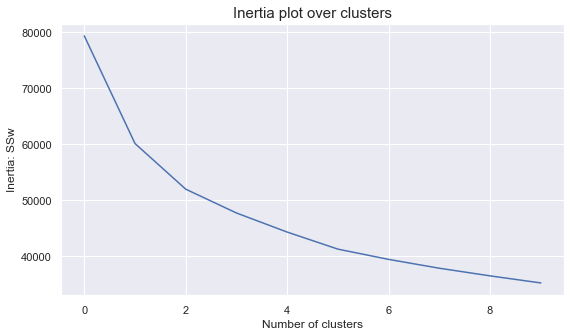

In [96]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.23411067052585513
For n_clusters = 3, the average silhouette_score is : 0.21300189708791797
For n_clusters = 4, the average silhouette_score is : 0.16375584322359385
For n_clusters = 5, the average silhouette_score is : 0.16351929821487668
For n_clusters = 6, the average silhouette_score is : 0.16745333090864442
For n_clusters = 7, the average silhouette_score is : 0.1669730154815064
For n_clusters = 8, the average silhouette_score is : 0.16313916187834276
For n_clusters = 9, the average silhouette_score is : 0.15077626884018194
For n_clusters = 10, the average silhouette_score is : 0.14382178793383313


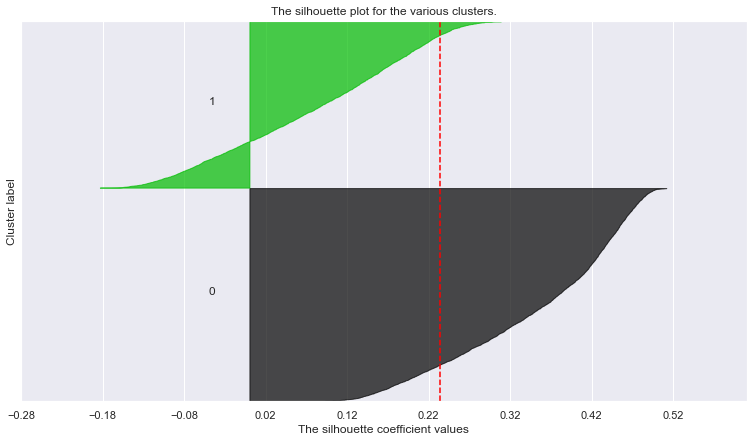

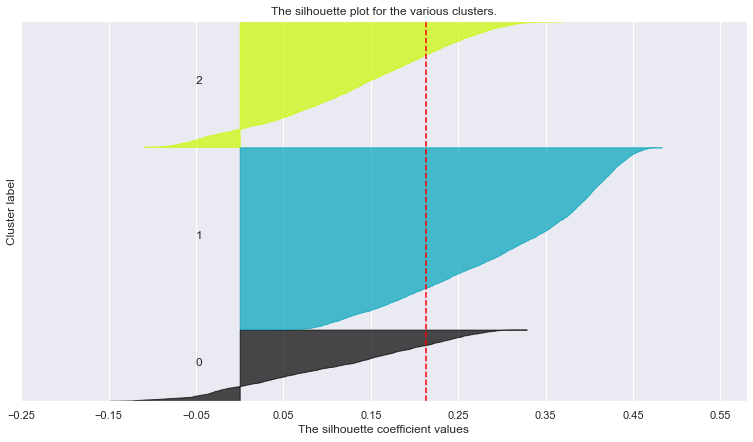

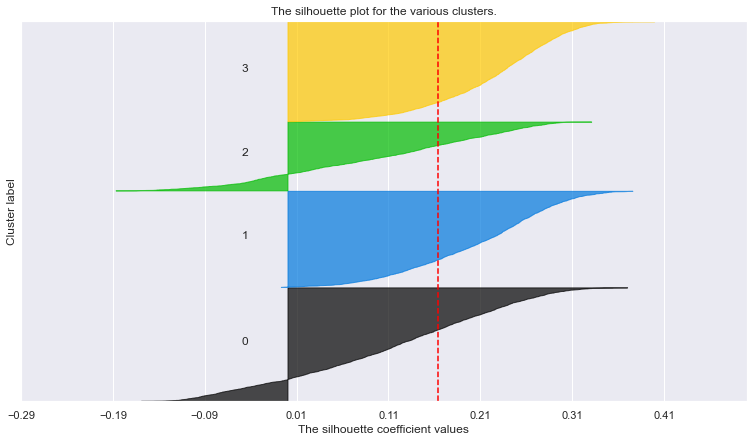

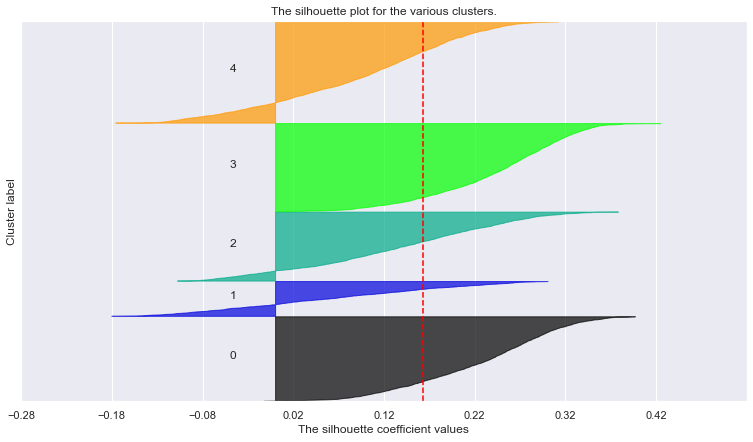

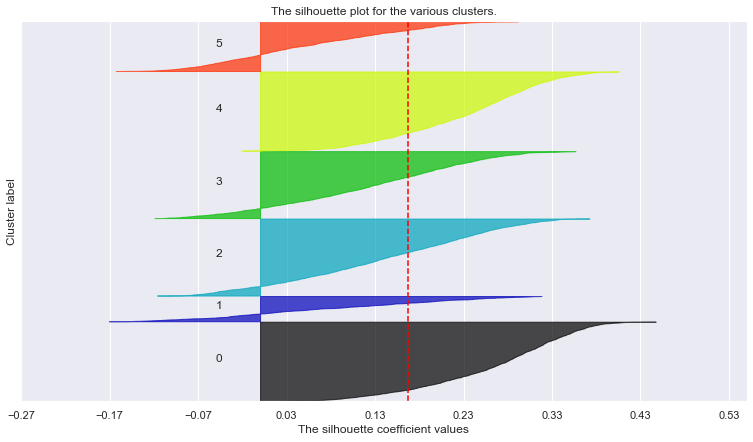

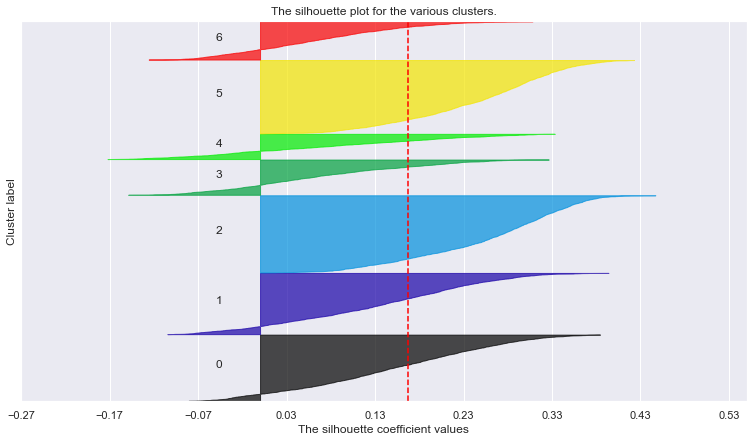

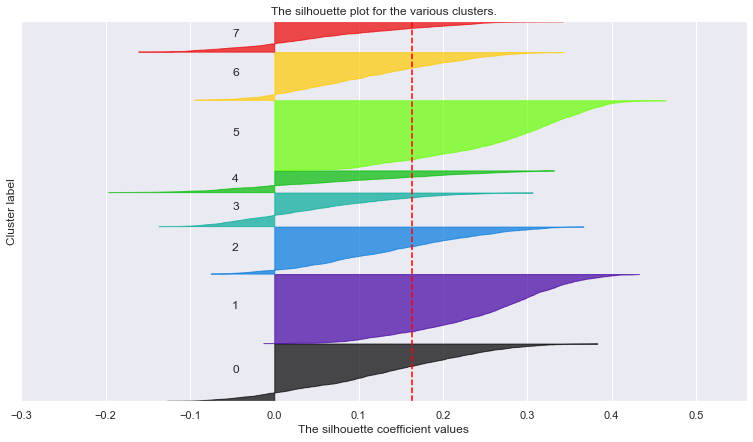

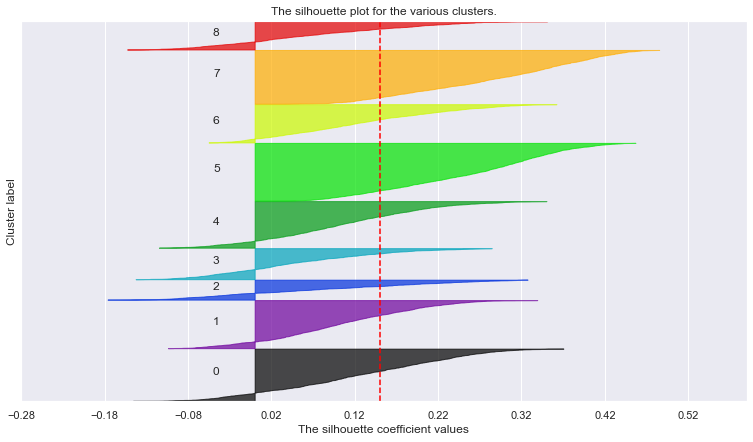

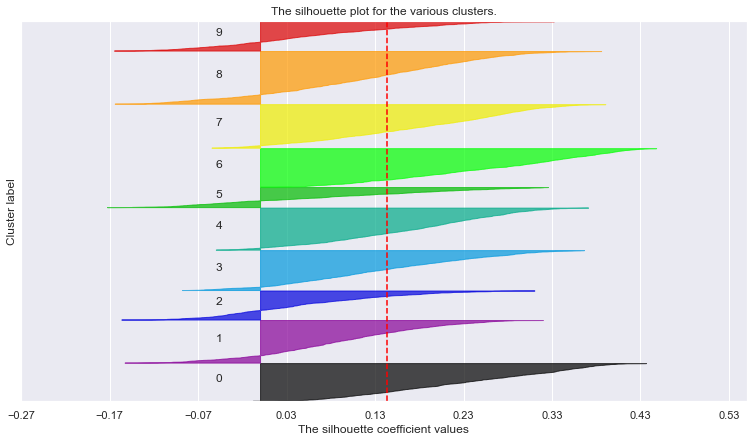

In [97]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[df_metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[df_metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[df_metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[df_metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

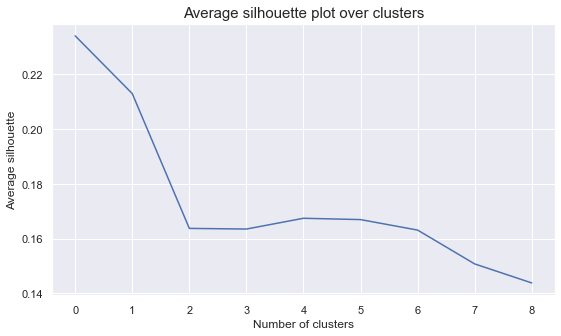

In [98]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final K-means clustering solution

In [99]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df[df_metric_features])
km_labels

array([1, 0, 0, ..., 1, 0, 1])

In [100]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,Education,Salary,Area,Children,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate
labels,,,,,,,,,,,,
0.0,2.606789,-0.023038,2.707921,0.727723,-0.021924,0.007761,-0.032989,0.001146,-0.020920,0.009052,0.005915,0.013608
1.0,2.602620,0.039278,2.733624,0.699509,0.007740,-0.018575,0.012108,0.024419,0.007756,0.002697,-0.009042,-0.016031
2.0,2.610535,-0.041183,2.666401,0.733440,-0.005912,0.023443,-0.020552,-0.029695,-0.006140,-0.009333,-0.006798,0.009193


### Self-Organizing-Maps (SOM)

In [101]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[df_metric_features].values, 
    mapsize=[10, 10],  # NEEDS TO BE A LIST
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.048000, quantization error: 2.961128

 epoch: 2 ---> elapsed time:  0.043000, quantization error: 2.793040

 epoch: 3 ---> elapsed time:  0.042000, quantization error: 2.751819

 epoch: 4 ---> elapsed time:  0.044000, quantization error: 2.716790

 epoch: 5 ---> elapsed time:  0.056000, quantization error: 2.686543

 epoch: 6 ---> elapsed time:  0.040000, quantization error: 2.659328

 epoch: 7 ---> elapsed time:  0.041000, quantization error: 2.636353

 epoch: 8 ---> elapsed time:  0.043000, quantization error: 2.630255

 epoch: 9 ---> elapsed time:  0.041000, quantization error: 2.626469

 epoch: 10 ---> elapsed time:  0.041000, quantization error: 2.623007

 epoch: 11 ---> elapsed time:  0.040000, quantization error: 2.619596

 epoch: 12 ---> elapsed time:  0.043000, quantization error: 2.616205

 epoch: 13 ---> 

 epoch: 14 ---> elapsed time:  0.048000, quantization error: 1.707546

 epoch: 15 ---> elapsed time:  0.052000, quantization error: 1.707384

 epoch: 16 ---> elapsed time:  0.050000, quantization error: 1.707223

 epoch: 17 ---> elapsed time:  0.050000, quantization error: 1.706967

 epoch: 18 ---> elapsed time:  0.051000, quantization error: 1.706801

 epoch: 19 ---> elapsed time:  0.049000, quantization error: 1.706626

 epoch: 20 ---> elapsed time:  0.048000, quantization error: 1.706545

 epoch: 21 ---> elapsed time:  0.044000, quantization error: 1.706353

 epoch: 22 ---> elapsed time:  0.043000, quantization error: 1.706161

 epoch: 23 ---> elapsed time:  0.043000, quantization error: 1.705979

 epoch: 24 ---> elapsed time:  0.043000, quantization error: 1.705773

 epoch: 25 ---> elapsed time:  0.044000, quantization error: 1.705578

 epoch: 26 ---> elapsed time:  0.043000, quantization error: 1.705391

 epoch: 27 ---> elapsed time:  0.045000, quantization error: 1.705276

 epoch

In [102]:
plt.rcParams['figure.dpi'] = 72

In [103]:
weights = sm.codebook.matrix 

In [104]:
###################################
### Visualizing Component Planes ##
###################################

def plot_component_planes(weights,
                          features,
                          M=3, N=4, 
                          figsize=(20,20),
                          figlayout=(3,4),
                          title="Component Planes",
                          cmap=cm.magma
                         ):
    
    xx, yy = np.meshgrid(np.arange(M), np.arange(N))
    xx = xx.astype(float)
    yy = yy.astype(float)

    xx[::-2] -= 0.5

    xx = xx.T
    yy = yy.T
    
    weights_ = weights.reshape((M,N,len(features)))

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    
    ## Normalize color scale to range of all values
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), 
                                         vmax=np.max(weights))

    for cpi, sf in zip(range(len(df_metric_features)), subfigs.flatten()):

        sf.suptitle(features[cpi], y=0.95)

        axs = sf.subplots(1,1, )
        axs.set_aspect('equal')

        ## Normalize color scale to range of values in each component
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:,:,cpi]), 
                                         vmax=np.max(weights_[:,:,cpi]))

        # iteratively add hexagons
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights_[i, j, cpi])), 
                                     alpha=1, 
                                     linewidth=.5,
                                     edgecolor=cmap(colornorm(weights_[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)


        ## only run this block if matplotlib >= 3.6.x
        mplv = [int(i) for i in mplver.split('.')]
        if mplv[1] >= 6:
            ## Add colorbar
            divider = make_axes_locatable(axs)

            ax_cb = divider.append_axes("right", size="7%")#, pad="2%")

            ## Create a Mappable object
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])

            ## Create custom colorbar 
            cb1 = colorbar.Colorbar(ax_cb,
                                    orientation='vertical', 
                                    alpha=1,
                                    mappable=cmap_sm
                                    )
            cb1.ax.get_yaxis().labelpad = 16

            ## Add colorbar to plot
            sf.add_axes(ax_cb)



        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")


    fig.suptitle(title)
    plt.show()

In [105]:
print("matplotlib version is:" , mplver)

matplotlib version is: 3.4.3


### Component Planes

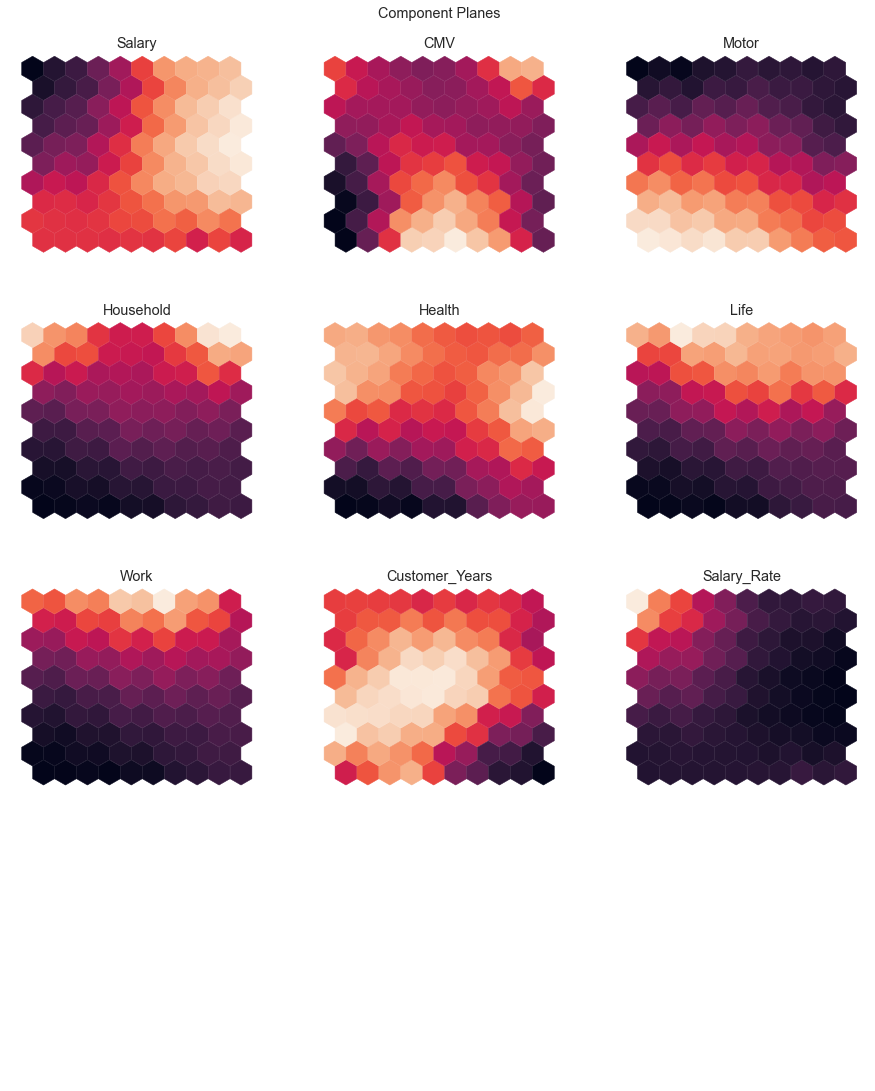

In [106]:
#### Use this if cell below does not work ####

plot_component_planes(weights=sm.codebook.matrix,features=df_metric_features,
                      M=10,N=10,
                      figsize=(12,15),figlayout=(4,3),
                      title="Component Planes",
                      cmap=sns.color_palette("rocket", as_cmap=True))


### U-Matrix

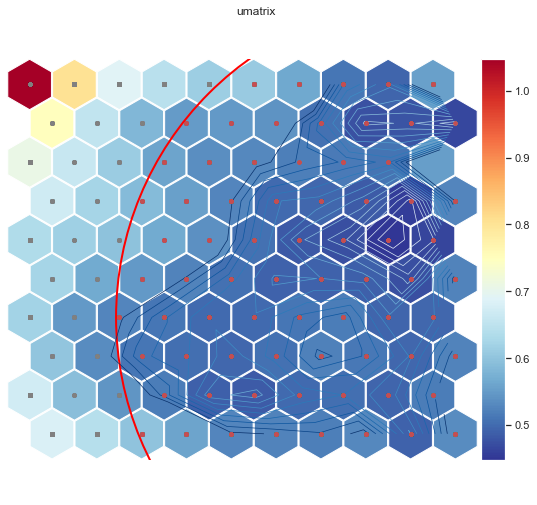

array([[1.04814219, 0.80324482, 0.6913439 , 0.64442643, 0.61384176,
        0.60912875, 0.56471334, 0.50853428, 0.49309381, 0.55333862],
       [0.74823915, 0.6525831 , 0.5835367 , 0.5500523 , 0.54622313,
        0.53947228, 0.50591148, 0.47333144, 0.47631086, 0.46609593],
       [0.70572233, 0.65943134, 0.60982717, 0.55882266, 0.53436527,
        0.52885897, 0.51880062, 0.51330404, 0.50649904, 0.55274182],
       [0.66878757, 0.62173535, 0.58797228, 0.55370972, 0.52557925,
        0.49765703, 0.49483784, 0.48302225, 0.45624312, 0.52574804],
       [0.63367412, 0.61525281, 0.59662676, 0.56672963, 0.53852108,
        0.50607235, 0.48222785, 0.47143669, 0.44750588, 0.46275069],
       [0.62139512, 0.56695708, 0.54636702, 0.52365524, 0.5047042 ,
        0.49046898, 0.49193392, 0.48867602, 0.47235232, 0.52278555],
       [0.6189034 , 0.54677687, 0.52665275, 0.50919966, 0.49866342,
        0.49820798, 0.50956014, 0.51751629, 0.4934101 , 0.49574784],
       [0.60104267, 0.53201719, 0.5098191

In [107]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2,
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=True
)

np.flip(UMAT[1], axis=1) # U-matrix values - they match with the plot colors

### Hit-Map

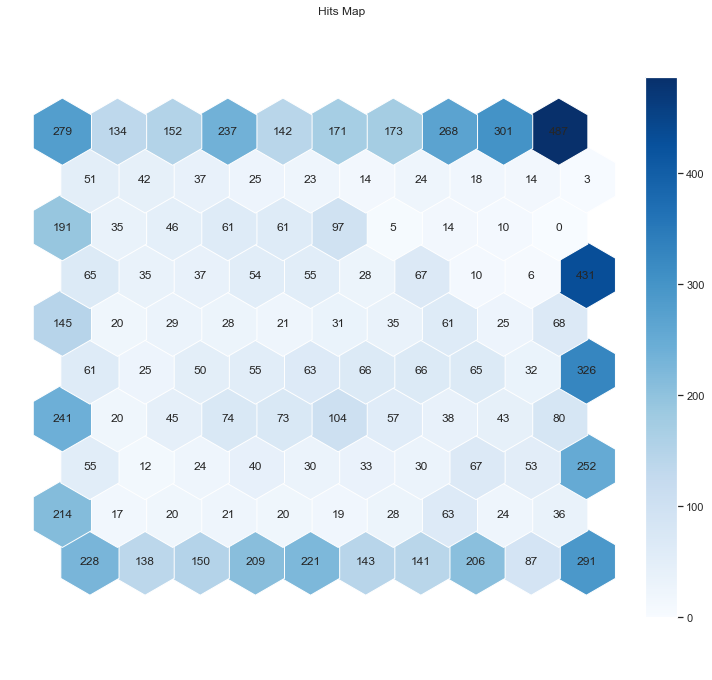

In [108]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

### K-Means on top of SOM units
- Define number of clusters to retain

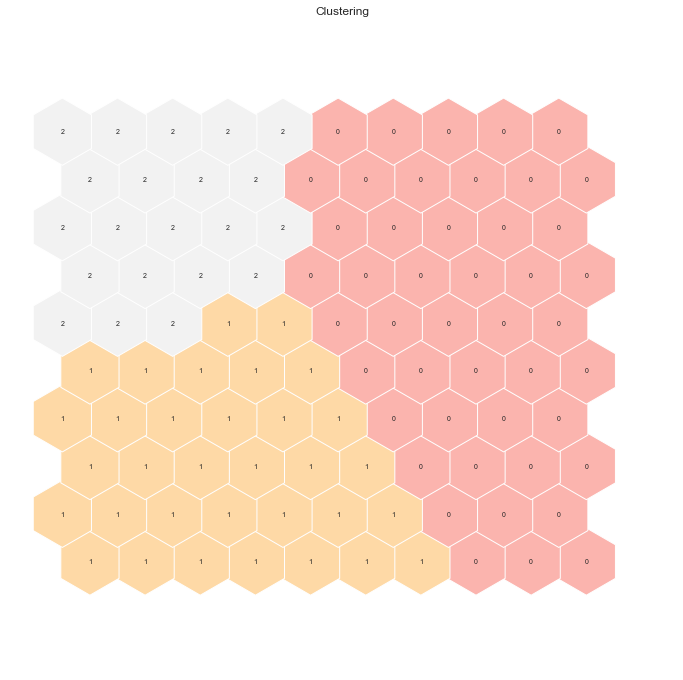

In [109]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Hierarchical Clustering on top of SOM units
- Define best linkage method
- Define number of clusters to retain

In [110]:
hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [111]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [112]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df[df_metric_features], hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.198283,0.061765,0.017080,0.004253,0.182924
3,0.282876,0.066529,0.080082,0.005571,0.265067
4,0.349614,0.200148,0.080359,0.005638,0.335482
5,0.386191,0.245516,0.084856,0.009695,0.378233
6,0.415118,0.285226,0.089908,0.012425,0.411612
7,0.440383,0.291559,0.090234,0.013427,0.437391
8,0.462977,0.382105,0.092776,0.015224,0.455861
9,0.481930,0.395347,0.176200,0.015266,0.472893


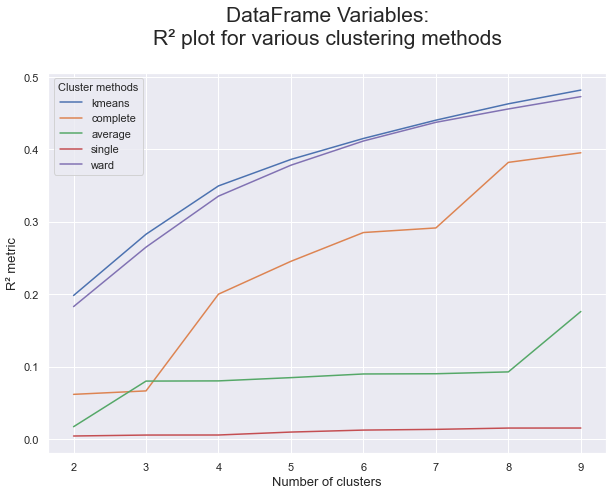

In [113]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("DataFrame Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

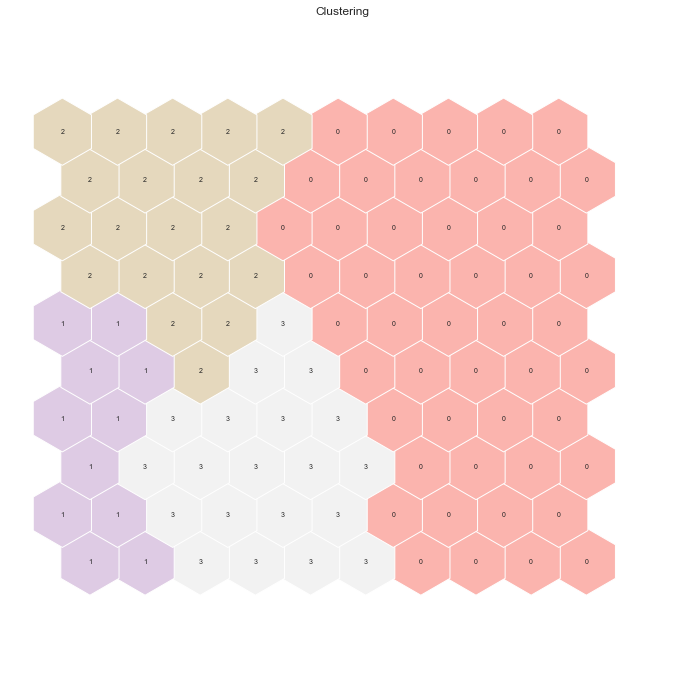

In [114]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Final SOM Clustering solution

In [115]:
# Check the nodes and and respective clusters
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=df_metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

,Salary,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate,label
0,-0.046759,-0.828690,1.290452,-0.761091,-1.163500,-0.770987,-0.745635,-0.153694,-0.345611,0
1,-0.016778,-0.828462,1.181318,-0.722335,-1.044320,-0.731655,-0.712188,0.409884,-0.342177,0
2,-0.094752,-0.787486,0.896546,-0.626719,-0.720585,-0.619240,-0.607345,0.681153,-0.265456,0
3,-0.394809,-0.700795,0.574984,-0.522034,-0.337451,-0.507016,-0.504112,0.639185,-0.048285,0
4,-0.694896,-0.572875,0.227918,-0.390058,0.066131,-0.367097,-0.367969,0.460043,0.231087,0
...,...,...,...,...,...,...,...,...,...,...
95,1.076617,-0.276098,-0.684737,-0.057736,1.074727,-0.020351,-0.055141,0.076151,-0.620269,3
96,1.064452,-0.244254,-0.856812,0.138758,1.093019,0.324920,0.146962,-0.228916,-0.578568,3
97,1.001070,-0.129054,-0.912930,0.496790,0.866632,0.781228,0.252945,-0.322136,-0.490069,3
98,0.888154,0.169642,-0.916277,1.088921,0.575040,0.919235,0.334224,-0.289206,-0.342706,1


In [116]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df[df_metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
    index=df.index, columns=np.append(df.columns,"BMU")
)
df_bmus

,Education,Salary,Area,Children,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate,BMU
CustID,,,,,,,,,,,,,
1,2.0,-0.485492,1.0,1.0,0.795649,0.399191,-0.513420,-0.293000,0.580715,-0.469815,0.152481,-0.089110,34.0
3,1.0,-0.375762,3.0,0.0,1.352802,-0.996534,0.470099,-0.577316,1.947546,2.416992,-0.758481,0.009578,49.0
4,3.0,-1.668382,4.0,1.0,-0.996790,-1.191212,-0.758198,1.858430,0.175252,-0.067356,-0.606654,1.127986,6.0
5,3.0,-0.939775,4.0,1.0,-0.761588,0.092987,-0.728025,0.179947,-0.400110,0.393451,0.000654,0.169579,4.0
6,2.0,-0.058643,4.0,1.0,-1.029850,0.932971,-0.923983,-0.704984,-0.809395,-0.793891,0.000654,-0.473860,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,2.0,0.964041,4.0,0.0,0.185933,-0.818305,0.782682,-0.102934,2.426319,1.393447,0.000654,-0.435902,79.0
10292,4.0,0.623878,2.0,0.0,-0.920761,0.546330,-0.716837,0.065332,-0.712806,-0.543979,0.304308,-0.617098,2.0
10294,3.0,0.327607,1.0,1.0,1.440316,0.627672,-0.151678,-0.346652,-0.612396,-0.891605,-1.213961,-0.428304,60.0


In [117]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

,Education,Salary,Area,Children,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate,BMU,label
CustID,,,,,,,,,,,,,,
1,2.0,-0.485492,1.0,1.0,0.795649,0.399191,-0.513420,-0.293000,0.580715,-0.469815,0.152481,-0.089110,34.0,0
3,1.0,-0.375762,3.0,0.0,1.352802,-0.996534,0.470099,-0.577316,1.947546,2.416992,-0.758481,0.009578,49.0,1
4,3.0,-1.668382,4.0,1.0,-0.996790,-1.191212,-0.758198,1.858430,0.175252,-0.067356,-0.606654,1.127986,6.0,2
5,3.0,-0.939775,4.0,1.0,-0.761588,0.092987,-0.728025,0.179947,-0.400110,0.393451,0.000654,0.169579,4.0,0
6,2.0,-0.058643,4.0,1.0,-1.029850,0.932971,-0.923983,-0.704984,-0.809395,-0.793891,0.000654,-0.473860,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,2.0,0.964041,4.0,0.0,0.185933,-0.818305,0.782682,-0.102934,2.426319,1.393447,0.000654,-0.435902,79.0,1
10292,4.0,0.623878,2.0,0.0,-0.920761,0.546330,-0.716837,0.065332,-0.712806,-0.543979,0.304308,-0.617098,2.0,0
10294,3.0,0.327607,1.0,1.0,1.440316,0.627672,-0.151678,-0.346652,-0.612396,-0.891605,-1.213961,-0.428304,60.0,0


In [118]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

,Education,Salary,Area,Children,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate
label,,,,,,,,,,,,
0,2.795649,0.017610,2.694573,0.826851,0.030641,0.770570,-0.524621,-0.616002,-0.552061,-0.534008,-0.045685,-0.289123
1,2.169244,0.510266,2.739691,0.511168,0.296860,-0.921924,1.119158,0.225434,0.914259,1.284635,-0.216912,-0.168487
2,2.405202,-1.216307,2.706358,0.897110,-0.029575,-0.886363,0.626960,0.788304,0.588824,0.477663,0.033389,1.357413
3,2.604938,1.038577,2.747277,0.286129,-0.315053,-0.653839,0.000150,0.854943,0.311960,0.078865,0.292400,-0.607412


## Analysing the appropriateness of our solution
### R²

In [119]:
# using R²
#def get_ss(df):
    #ss = np.sum(df.var() * (df.count() - 1))
    #return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[df_metric_features])  # get total sum of squares
ssw_labels = df_final[df_metric_features + ["label"]].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.3589591841425333

### Density Based Clustering

### Mean Shift Clustering

In [120]:
# The following bandwidth can be automatically detected using (we need to set quantile though)
# Based on distance to nearest neighbors for all observations
bandwidth = estimate_bandwidth(df[df_metric_features], quantile=0.06, random_state=1, n_jobs=-1)
bandwidth

2.309737260852959

In [121]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df[df_metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 16


In [122]:
# Concatenating the labels to df
df_concat = pd.concat([df[df_metric_features], pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_concat.head()

,Salary,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate,ms_labels
CustID,,,,,,,,,,
1,-0.485492,0.795649,0.399191,-0.513420,-0.293000,0.580715,-0.469815,0.152481,-0.089110,0
3,-0.375762,1.352802,-0.996534,0.470099,-0.577316,1.947546,2.416992,-0.758481,0.009578,9
4,-1.668382,-0.996790,-1.191212,-0.758198,1.858430,0.175252,-0.067356,-0.606654,1.127986,0
5,-0.939775,-0.761588,0.092987,-0.728025,0.179947,-0.400110,0.393451,0.000654,0.169579,0
6,-0.058643,-1.029850,0.932971,-0.923983,-0.704984,-0.809395,-0.793891,0.000654,-0.473860,0


In [123]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[df_metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2260


### DBSCAN (Density-based spatial clustering of applications with noise)

In [124]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[df_metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


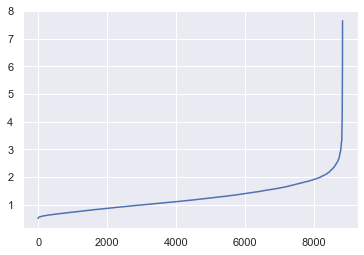

In [125]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df[df_metric_features])
distances, _ = neigh.kneighbors(df[df_metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [126]:
# Concatenating the labels to df
df_concat = pd.concat([df[df_metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

,Salary,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate,dbscan_labels
CustID,,,,,,,,,,
1,-0.485492,0.795649,0.399191,-0.513420,-0.293000,0.580715,-0.469815,0.152481,-0.089110,0
3,-0.375762,1.352802,-0.996534,0.470099,-0.577316,1.947546,2.416992,-0.758481,0.009578,0
4,-1.668382,-0.996790,-1.191212,-0.758198,1.858430,0.175252,-0.067356,-0.606654,1.127986,0
5,-0.939775,-0.761588,0.092987,-0.728025,0.179947,-0.400110,0.393451,0.000654,0.169579,0
6,-0.058643,-1.029850,0.932971,-0.923983,-0.704984,-0.809395,-0.793891,0.000654,-0.473860,0


In [127]:
# Detecting noise (potential outliers)
df_concat.loc[df_concat['dbscan_labels'] == -1]

,Salary,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate,dbscan_labels
CustID,,,,,,,,,,
139,-0.089367,-0.246502,-1.094325,1.020002,-2.203584,0.244740,-0.442398,1.063442,-0.529256,-1
169,-1.857118,0.003789,-1.392304,1.072890,0.999608,2.183111,-0.715859,1.367096,2.835136,-1
183,-1.967945,-0.317081,-1.384985,3.246735,0.501989,1.503517,-0.239236,-1.365788,5.078544,-1
185,-0.219946,-1.200554,-2.692047,0.669786,0.806669,-0.847961,0.452150,-1.062134,-0.519424,-1
246,-2.253243,-1.012824,-2.426967,1.811292,1.745252,2.464885,1.518578,0.304308,6.684706,-1
...,...,...,...,...,...,...,...,...,...,...
10091,1.587308,3.058041,-0.204088,2.647673,-1.473865,2.325909,0.241255,0.304308,-0.343474,-1
10134,-2.196183,1.047426,-0.487427,0.843029,0.412047,-0.639497,1.530177,-0.758481,5.182331,-1
10144,-2.073286,2.292710,-1.125414,2.350007,-0.320544,0.549793,2.866200,0.607962,5.249665,-1


In [128]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df[df_metric_features])  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.1181


### GMM (Gaussian Mixture Model )

In [129]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df[df_metric_features])
labels_proba = gmm.predict_proba(df[df_metric_features])

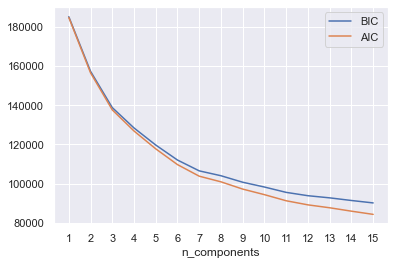

In [130]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[df_metric_features])
          for n in n_components]

bic_values = [m.bic(df[df_metric_features]) for m in models]
aic_values = [m.aic(df[df_metric_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [131]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df[df_metric_features])

In [132]:
# Concatenating the labels to df
df_concat = pd.concat([df[df_metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.head()

,Salary,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate,gmm_labels
CustID,,,,,,,,,,
1,-0.485492,0.795649,0.399191,-0.513420,-0.293000,0.580715,-0.469815,0.152481,-0.089110,1
3,-0.375762,1.352802,-0.996534,0.470099,-0.577316,1.947546,2.416992,-0.758481,0.009578,1
4,-1.668382,-0.996790,-1.191212,-0.758198,1.858430,0.175252,-0.067356,-0.606654,1.127986,1
5,-0.939775,-0.761588,0.092987,-0.728025,0.179947,-0.400110,0.393451,0.000654,0.169579,2
6,-0.058643,-1.029850,0.932971,-0.923983,-0.704984,-0.809395,-0.793891,0.000654,-0.473860,2


In [133]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[df_metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2768


### Testing on K-means and Hierarchical clustering


In [134]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [135]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(demo_df, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        demo_df, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.415599,0.164196,0.405209,0.013723,0.379815
3,0.554301,0.223970,0.405975,0.025002,0.523236
4,0.641374,0.358038,0.407129,0.028143,0.581154
5,0.686444,0.449514,0.521399,0.033341,0.624485
6,0.717949,0.469360,0.585650,0.040200,0.657388
7,0.746680,0.517687,0.605398,0.044380,0.685128
8,0.766718,0.582094,0.633371,0.057309,0.707533
9,0.784925,0.605534,0.651638,0.084339,0.729798


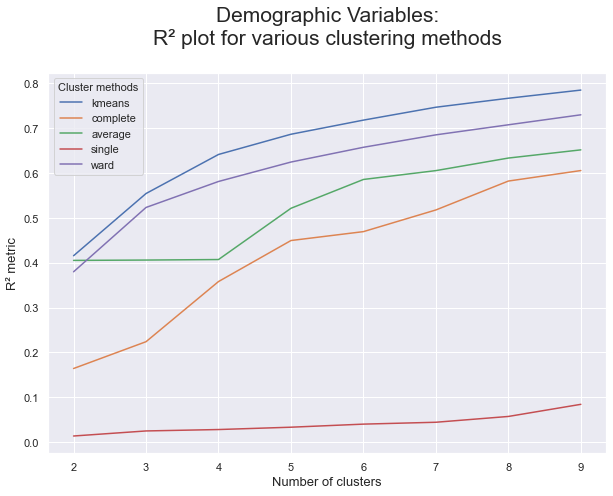

In [136]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Repeat Process For Insurance

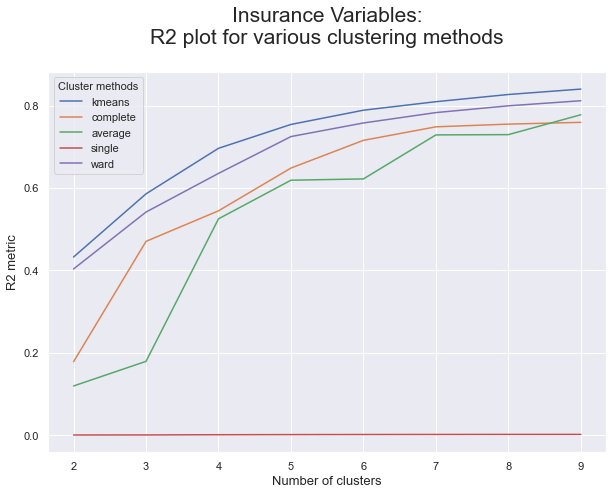

In [137]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(insurance_df, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        insurance_df, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Insurance Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

In [138]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_prod = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
insurance_labels = kmeans_prod.fit_predict(insurance_df)

kmeans_behav = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
demo_labels = kmeans_behav.fit_predict(demo_df)

df['insurance_labels'] = insurance_labels
df['demo_labels'] = demo_labels

In [139]:
# Count label frequencies (contigency table)
df.groupby(['insurance_labels', 'demo_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('demo_labels', 'insurance_labels', 0)

insurance_labels,0,1,2,3
demo_labels,,,,
0,790,286,859,891
1,478,182,454,453
2,787,282,693,732
3,526,217,576,616


### Merging using Hierarchical Clustering

In [140]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['demo_labels', 'insurance_labels'])\
    [df_metric_features].mean()
df_centroids

Salary       CMV     Motor  Household  \
demo_labels insurance_labels                                            
0           0                -1.042485 -0.437102 -0.923466   0.650263   
            1                -1.086700  1.399213 -1.014408   1.562340   
            2                -0.635838  0.961410  0.663564  -0.539484   
            3                -0.605101 -0.983765  0.652111  -0.642267   
1           0                 1.079453 -0.426820 -0.878500   0.579356   
            1                 1.064589  1.362165 -0.919123   1.579211   
            2                 0.803260  0.897608  0.560636  -0.473695   
            3                 0.816680 -0.952620  0.534009  -0.591616   
2           0                 1.008065 -0.409110 -0.834159   0.523245   
            1                 0.961158  1.327304 -0.800246   1.534947   
            2                 0.787610  0.908029  0.562603  -0.470626   
            3                 0.847484 -0.968314  0.500011  -0.600060   
3           0                -1.008033 -0.411330 -0.931556   0.545206   
            1                -1.017617  1.330536 -1.041650   1.628155   
            2                -0.613006  0.936705  0.681412  -0.545336   
            3                -0.569979 -0.988229  0.664284  -0.667832   

                                Health      Life      Work  Customer_Years  \
demo_labels insurance_labels                                                 
0           0                 0.741335  0.643109  0.606822       -0.008955   
            1                 0.412118  0.804746  0.804053       -0.052963   
            2                -0.479645 -0.445713 -0.445926        0.035297   
            3                -0.457685 -0.450883 -0.411405        0.047344   
1           0                 0.789579  0.453246  0.432902       -0.031427   
            1                 0.403277  0.712145  0.585122       -0.148670   
            2                -0.429215 -0.333075 -0.325854       -0.014729   
            3                -0.401509 -0.333266 -0.338923       -0.023813   
2           0                 0.772085  0.504066  0.442225        0.006634   
            1                 0.281811  0.567903  0.605546       -0.012267   
            2                -0.441863 -0.333710 -0.322317        0.006350   
            3                -0.332561 -0.328907 -0.289914       -0.027139   
3           0                 0.796606  0.586812  0.581287        0.033559   
            1                 0.487344  0.724339  0.837232        0.047531   
            2                -0.520121 -0.458085 -0.458775       -0.023860   
            3                -0.520145 -0.461851 -0.451428        0.014210   

                              Salary_Rate  
demo_labels insurance_labels               
0           0                    1.093672  
            1                    1.534987  
            2                    0.087727  
            3                    0.025273  
1           0                   -0.527908  
            1                   -0.346142  
            2                   -0.623434  
            3                   -0.656406  
2           0                   -0.508491  
            1                   -0.315805  
            2                   -0.620069  
            3                   -0.659794  
3           0                    1.023883  
            1                    1.520706  
            2                    0.075837  
            3                   -0.025121

In [141]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

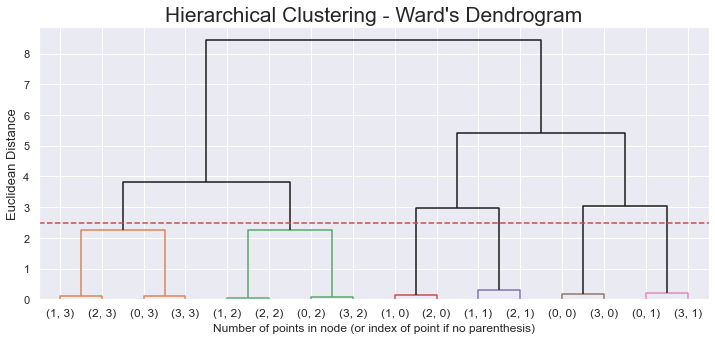

In [142]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(12,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.5
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [143]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Salary       CMV     Motor  Household  \
demo_labels insurance_labels                                            
0           0                -1.042485 -0.437102 -0.923466   0.650263   
            1                -1.086700  1.399213 -1.014408   1.562340   
            2                -0.635838  0.961410  0.663564  -0.539484   
            3                -0.605101 -0.983765  0.652111  -0.642267   
1           0                 1.079453 -0.426820 -0.878500   0.579356   
            1                 1.064589  1.362165 -0.919123   1.579211   
            2                 0.803260  0.897608  0.560636  -0.473695   
            3                 0.816680 -0.952620  0.534009  -0.591616   
2           0                 1.008065 -0.409110 -0.834159   0.523245   
            1                 0.961158  1.327304 -0.800246   1.534947   
            2                 0.787610  0.908029  0.562603  -0.470626   
            3                 0.847484 -0.968314  0.500011  -0.600060   
3           0                -1.008033 -0.411330 -0.931556   0.545206   
            1                -1.017617  1.330536 -1.041650   1.628155   
            2                -0.613006  0.936705  0.681412  -0.545336   
            3                -0.569979 -0.988229  0.664284  -0.667832   

                                Health      Life      Work  Customer_Years  \
demo_labels insurance_labels                                                 
0           0                 0.741335  0.643109  0.606822       -0.008955   
            1                 0.412118  0.804746  0.804053       -0.052963   
            2                -0.479645 -0.445713 -0.445926        0.035297   
            3                -0.457685 -0.450883 -0.411405        0.047344   
1           0                 0.789579  0.453246  0.432902       -0.031427   
            1                 0.403277  0.712145  0.585122       -0.148670   
            2                -0.429215 -0.333075 -0.325854       -0.014729   
            3                -0.401509 -0.333266 -0.338923       -0.023813   
2           0                 0.772085  0.504066  0.442225        0.006634   
            1                 0.281811  0.567903  0.605546       -0.012267   
            2                -0.441863 -0.333710 -0.322317        0.006350   
            3                -0.332561 -0.328907 -0.289914       -0.027139   
3           0                 0.796606  0.586812  0.581287        0.033559   
            1                 0.487344  0.724339  0.837232        0.047531   
            2                -0.520121 -0.458085 -0.458775       -0.023860   
            3                -0.520145 -0.461851 -0.451428        0.014210   

                              Salary_Rate  hclust_labels  
demo_labels insurance_labels                              
0           0                    1.093672              4  
            1                    1.534987              2  
            2                    0.087727              0  
            3                    0.025273              1  
1           0                   -0.527908              5  
            1                   -0.346142              3  
            2                   -0.623434              0  
            3                   -0.656406              1  
2           0                   -0.508491              5  
            1                   -0.315805              3  
            2                   -0.620069              0  
            3                   -0.659794              1  
3           0                    1.023883              4  
            1                    1.520706              2  
            2                    0.075837              0  
            3                   -0.025121              1

In [144]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['demo_labels'], row['insurance_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[df_metric_features]

,Salary,CMV,Motor,Household,Health,Life,Work,Customer_Years,Salary_Rate
merged_labels,,,,,,,,,
0,0.004345,0.930353,0.622350,-0.510740,-0.469667,-0.398606,-0.394504,0.005535,-0.229941
1,0.037170,-0.975344,0.593664,-0.628117,-0.428501,-0.400433,-0.375331,0.007535,-0.287250
2,-1.056897,1.369585,-1.026160,1.590733,0.444571,0.770058,0.818367,-0.009609,1.528826
3,1.001728,1.340978,-0.846874,1.552309,0.329455,0.624480,0.597535,-0.065770,-0.327704
4,-1.028715,-0.426801,-0.926699,0.608272,0.763426,0.620607,0.596615,0.008038,1.065777
5,1.035040,-0.415802,-0.850914,0.544447,0.778695,0.484863,0.438702,-0.007748,-0.515828


In [145]:
df = df_.copy()

In [146]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['demo_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['insurance_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('demo_labels', 'insurance_labels', 0)

insurance_labels,0,1,2,3
demo_labels,,,,
2,1265.0,464.0,NaN,NaN
3,1316.0,503.0,2582.0,2692.0


### Cluster Analysis

In [147]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

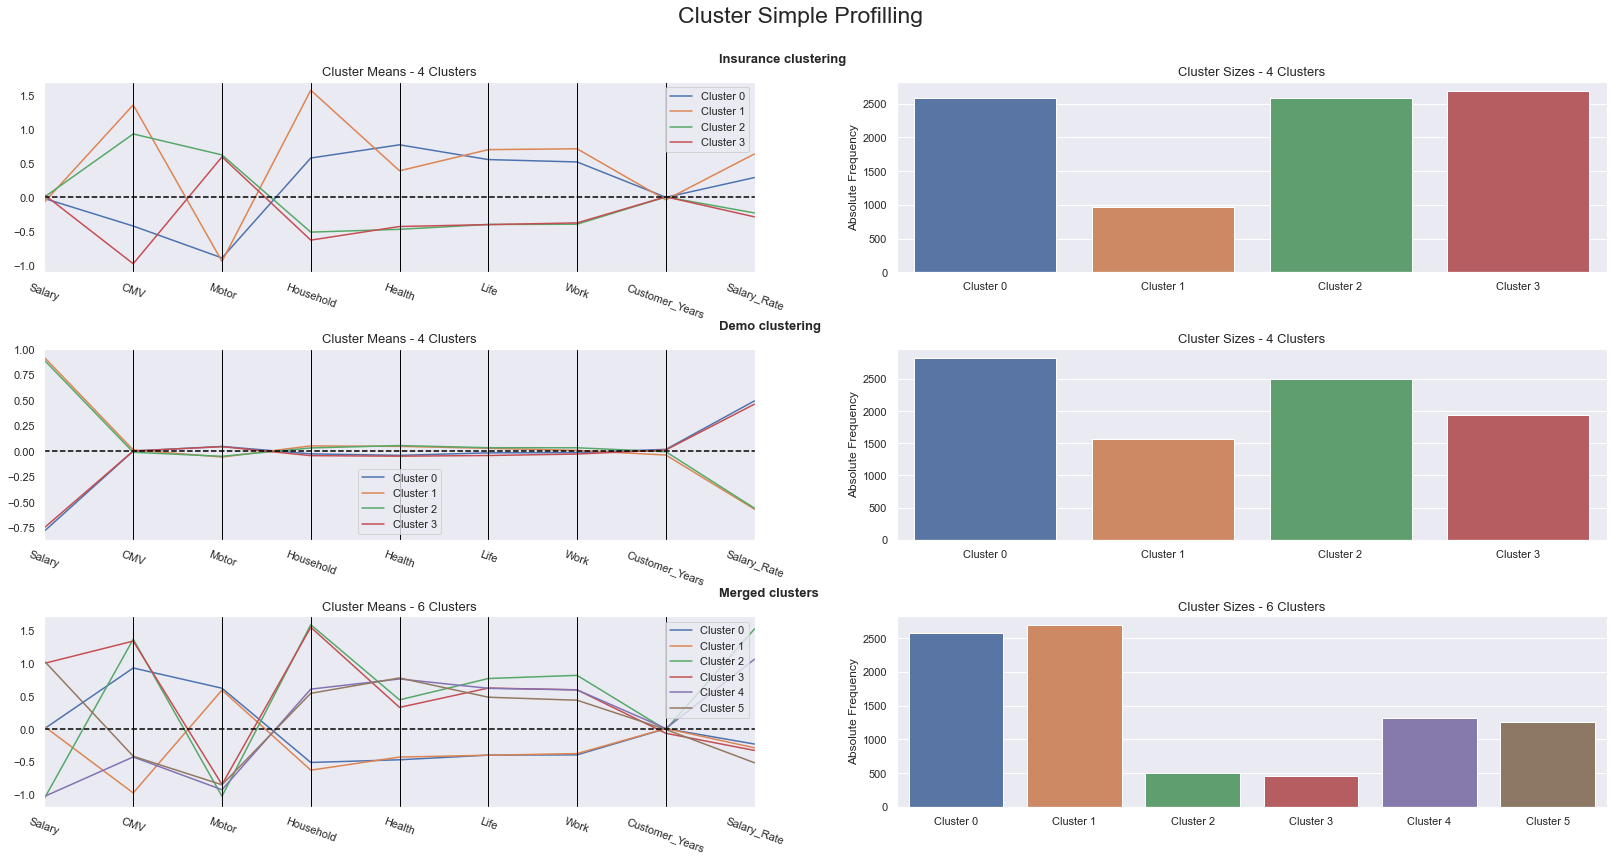

In [148]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[df_metric_features + ['insurance_labels', 'demo_labels', 'merged_labels']], 
    label_columns = ['insurance_labels', 'demo_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Insurance clustering", "Demo clustering", "Merged clusters"]
)

### Cluster Visualization using t-SNE

In [149]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[df_metric_features])

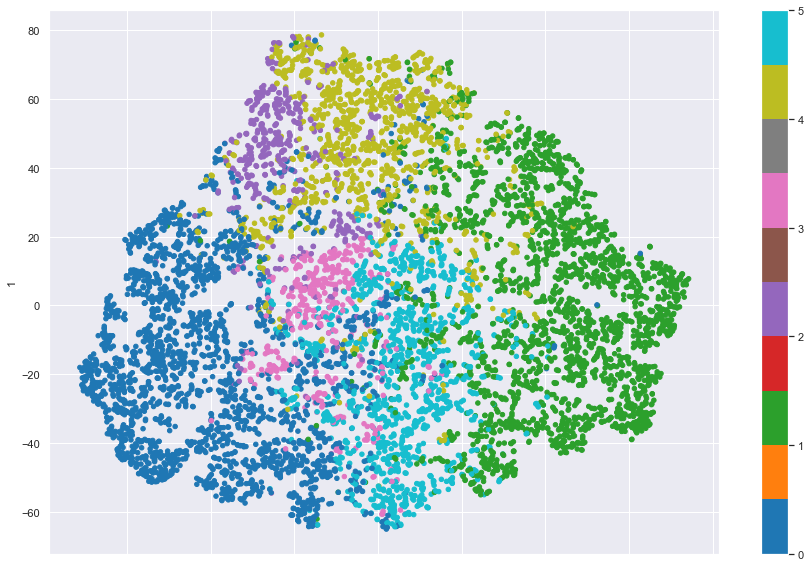

In [150]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()